Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlt

data = pd.read_stata("callreports_final.dta", chunksize=100000, preserve_dtypes=True)

df_raw = pd.DataFrame()

for chunk in data:
    df_raw=df_raw.append(chunk)

Additional Settings

In [210]:
%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import ticker
import matplotlib.patches as mpatches
from scipy.stats import pearsonr
from matplotlib import cm
import datetime
import itertools
import scipy.stats as scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

#setting matplotlib style
plt.style.use('default')

#setting params for matplolib plots
plt.rcParams['font.size']=BIGGER_SIZE          # controls default text sizes
plt.rcParams['axes.titlesize']=BIGGER_SIZE     # fontsize of the axes title
plt.rcParams['axes.labelsize']=BIGGER_SIZE    # fontsize of the x and y labels
plt.rcParams['xtick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['ytick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['legend.fontsize']=BIGGER_SIZE    # legend fontsize
plt.rcParams['figure.titlesize']=BIGGER_SIZE  # fontsize of the figure title
plt.rcParams['xtick.bottom']=True  # fontsize of the figure title
plt.rcParams['xtick.major.bottom']=True  # fontsize of the figure title
plt.rcParams['xtick.major.size']=3.5  # fontsize of the figure title
#plt.rcParams['xtick.major.width']=1  # fontsize of the figure title
plt.rcParams['xtick.major.top']=False  # fontsize of the figure title
plt.rcParams['xtick.minor.bottom']=True  # fontsize of the figure title
plt.rcParams['xtick.minor.size']=3  # fontsize of the figure title
#plt.rcParams['legend.fontsize'] = 22

#setting grid style
plt.rcParams['grid.color'] = 'k'
#plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5

#figsizes
figsize_OneGraph=(20,10)



categories = ["Top 10 banks", "Large banks", "Medium banks", "Small banks"]

Structural adjustments on dataset

In [211]:
#removing investment banks Goldman Sachs and Morgan Stanley
df_raw = df_raw[(df_raw.rssdid!=1456501) & (df_raw.bhcid!=2380443)]

Parse time

In [212]:
df_raw["date"] = pd.to_datetime(df_raw.date, format='%Y%m%d')

Timeseries labels for xaxis 

In [213]:
years = [str(year) for year in range(1976, 2014)]

years16 = [str(year) for year in range(1976, 2014, 4)]

Functions for plotting crisis shades on graph

In [214]:
def plot_crisis(ax):
    #1980Q1-Q3 crisis
    ax.axvspan(16, 19, alpha=0.5, color='gray')


    #1981Q3-1982Q4 crisis
    ax.axvspan(22, 27, alpha=0.5, color='gray')

    #1990Q3-1991Q2 crisis
    ax.axvspan(58, 61, alpha=0.5, color='gray')

    #2001Q2-2001Q4 crisis
    ax.axvspan(101, 103, alpha=0.5, color='gray')

    #2007Q4-2009Q3 crisis
    ax.axvspan(127, 134, alpha=0.5, color='gray')


In [215]:
'''
Takes xaxis with datetime objects
'''
def plot_crisis_datetime(ax):
    #1980 crisis
    ax.axvspan(datetime.datetime(1980,3,31), datetime.datetime(1980,9,30), alpha=0.5, color='gray')
    
    
    #1981Q3-1982Q4 crisis
    ax.axvspan(datetime.datetime(1981,9,30), datetime.datetime(1982,12,31), alpha=0.5, color='gray')
    
    #1990Q3-1991Q2 crisis
    ax.axvspan(datetime.datetime(1990,9,30), datetime.datetime(1991,6,30), alpha=0.5, color='gray')
    
    #2001Q2-2001Q4 crisis
    ax.axvspan(datetime.datetime(2001,6,30), datetime.datetime(2001,12,31), alpha=0.5, color='gray')
    
    #2007Q4-2009Q3 crisis
    ax.axvspan(datetime.datetime(2007,12,31), datetime.datetime(2009,9,30), alpha=0.5, color='gray')

Make ax-settings

In [216]:
def axsetting(ax):
    year_locator = mlt.dates.YearLocator(1, month=3, day=31)
    years_fmt = mlt.dates.DateFormatter('%Y')

    ax.xaxis.set_major_locator(year_locator)
    ax.xaxis.set_major_formatter(years_fmt)
    #plt.xticks(rotation=60)
    ax.tick_params(axis="x", labelrotation=60)
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.grid()
    ax.set_xlim(datetime.datetime(1976,3,31), datetime.datetime(2013,12,31))

    plot_crisis_datetime(ax)
    
def axsetting2(ax):
    year_locator = mlt.dates.YearLocator(1, month=1, day=1)
    ax.xaxis.set_minor_locator(year_locator)
    ax.grid()
    ax.set_xlim(datetime.datetime(1976,3,31), datetime.datetime(2013,12,31))

    plot_crisis_datetime(ax)
    
def catlegend(ax):
    ax.legend(["Top 10", "Large", "Medium", "Small"], loc="upper left")

Save function

In [217]:
def save(name):
    plt.tight_layout()
    plt.savefig('LatexVorlage/graphs/DescriptiveStats/BanksByAssetCategory_' + name + "_7613.png")

Analysing asset side & liability side

In [218]:
#getting relevant data
df_assets = df_raw[["date","rssdid","bhcid",  "name", 'year', "quarter","assets", "cash"
                     ,"fedfundsrepoasset" ,"securities","loansnet", "tradingassets"]]

df_liab = df_raw[["date","rssdid","bhcid" ,"name", 'year', "quarter","assets", "equity","fedfundsrepoliab" ,
                     "deposits","foreigndep", "otherborrowedmoney", 
                  "tradingliabilities","subordinateddebt", "liabilities"]]

Get bank categories:
    - cat1: 10 largest banks
    - cat2: large banks (those ranked 11 through 100)
    - cat3: medium-sized banks (those ranked 101 through 1,000)
    - cat4: small banks (those ranked 1,001 and higher)

Get min max per category and year

In [219]:
#dataframes to save every asset group without aggregation
df_cat1_banks = pd.DataFrame()
df_cat2_banks = pd.DataFrame()
df_cat3_banks = pd.DataFrame()
df_cat4_banks = pd.DataFrame()

#dataframes to save every liab group without aggregation
df_cat1_banks_liab = pd.DataFrame()
df_cat2_banks_liab = pd.DataFrame()
df_cat3_banks_liab = pd.DataFrame()
df_cat4_banks_liab = pd.DataFrame()

array_cat_group_liab = []

#Dataframes for min and max per asset size category
cat1_minmax = pd.DataFrame(columns=["min", "max"])
cat2_minmax = pd.DataFrame(columns=["min", "max"])
cat3_minmax = pd.DataFrame(columns=["min", "max"])
cat4_minmax = pd.DataFrame(columns=["min", "max"])

array_cat_minmax = [cat1_minmax, cat2_minmax, cat3_minmax, cat4_minmax]

def get_save_cat(gr, cat):
    global df_cat1_banks
    global df_cat2_banks
    global df_cat3_banks
    global df_cat4_banks
    if cat == 1:
        df_cat1_banks = df_cat1_banks.append(gr.iloc[:10,:])
        return gr.iloc[:10,:]
    elif cat == 2:
        df_cat2_banks = df_cat2_banks.append(gr.iloc[10:100,:])
        return gr.iloc[10:100,:]
    elif cat == 3:
        df_cat3_banks = df_cat3_banks.append(gr.iloc[100:1000,:])
        return gr.iloc[100:1000,:]
    elif cat == 4:
        df_cat4_banks = df_cat4_banks.append(gr.iloc[1000:,:])
        return gr.iloc[1000:,:]

grouped = df_assets.groupby(["date"])

for i in range(1,5):
    for name, gr in grouped:
        gr = gr.sort_values(by="assets", ascending=False)
        gr = get_save_cat(gr,i)
        #get min and max
        minmax = {"max" : gr.assets.max(), "min" : gr.assets.min()}
        temp_s = pd.Series(minmax, name=name)
        #add to minmax dataframe
        array_cat_minmax[i-1] =  array_cat_minmax[i-1].append(temp_s)
        
cat1_minmax = array_cat_minmax[0]
cat2_minmax = array_cat_minmax[1]
cat3_minmax = array_cat_minmax[2]
cat4_minmax = array_cat_minmax[3]


array_cat_group = [df_cat1_banks,
                    df_cat2_banks,
                    df_cat3_banks,
                    df_cat4_banks]

array_cat_group_liab = []

grouped = df_liab.groupby(["date"])



for i in range(1,5):
    temp_df = pd.DataFrame()
    for name, gr in grouped:
        gr = gr.sort_values(by="assets", ascending=False)
        gr = get_save_cat(gr,i)
        temp_df = temp_df.append(gr)
    array_cat_group_liab.append(temp_df)
    



In [220]:
pd.options.display.float_format = '{:.3e}'.format

pd.concat([cat1_minmax, cat2_minmax, cat3_minmax, cat4_minmax], axis=1, 
          keys=['Top 10', 'Top 11-100', 'Top 101-1000', "Top 1000-Rest"]).iloc[::8, :]

Top 10           Top 11-100           Top 101-1000           Top 1000-Rest          
                 min       max        min       max          min       max           min       max
1976-03-31 1.501e+07 6.289e+07  1.059e+06 1.185e+07    9.971e+04 1.059e+06     5.160e+02 9.960e+04
1978-03-31 1.828e+07 8.046e+07  1.359e+06 1.529e+07    1.220e+05 1.355e+06     6.880e+02 1.220e+05
1980-03-31 2.440e+07 1.010e+08  1.737e+06 1.961e+07    1.447e+05 1.734e+06     6.320e+02 1.444e+05
1982-03-31 3.067e+07 1.154e+08  2.159e+06 2.207e+07    1.710e+05 2.153e+06     5.230e+02 1.707e+05
1984-03-31 3.498e+07 1.158e+08  2.675e+06 2.431e+07    2.107e+05 2.654e+06     4.950e+02 2.107e+05
1986-03-31 2.901e+07 1.437e+08  3.640e+06 2.643e+07    2.421e+05 3.566e+06     4.660e+02 2.420e+05
1988-03-31 3.666e+07 1.535e+08  4.423e+06 3.059e+07    2.624e+05 4.341e+06     4.580e+02 2.618e+05
1990-03-31 4.565e+07 1.668e+08  5.198e+06 3.786e+07    2.879e+05 5.177e+06     3.280e+02 2.875e+05
1992-03-31 3.752e+07 1.643e+08  5.707e+06 3.377e+07    3.036e+05 5.690e+06     1.690e+02 3.028e+05
1994-03-31 3.877e+07 1.992e+08  6.044e+06 3.867e+07    3.045e+05 6.044e+06     1.026e+03 3.045e+05
1996-03-31 4.711e+07 2.212e+08  7.301e+06 4.607e+07    3.230e+05 7.170e+06     1.120e+02 3.228e+05
1998-03-31 6.882e+07 2.987e+08  6.189e+06 6.693e+07    3.172e+05 6.145e+06     1.257e+03 3.170e+05
2000-03-31 8.224e+07 5.854e+08  6.843e+06 7.596e+07    3.273e+05 6.825e+06     1.001e+03 3.272e+05
2002-03-31 8.469e+07 5.413e+08  7.629e+06 7.395e+07    3.592e+05 7.396e+06     1.745e+03 3.590e+05
2004-03-31 9.987e+07 6.906e+08  7.200e+06 8.936e+07    4.052e+05 7.034e+06     2.368e+03 4.051e+05
2006-03-31 8.888e+07 1.105e+09  7.847e+06 8.775e+07    4.735e+05 7.840e+06     2.709e+03 4.733e+05
2008-03-31 1.525e+08 1.408e+09  7.125e+06 1.475e+08    5.063e+05 6.644e+06     1.000e+03 5.058e+05
2010-03-31 1.610e+08 1.675e+09  7.357e+06 1.579e+08    5.244e+05 7.191e+06     1.070e+02 5.231e+05
2012-03-31 1.840e+08 1.843e+09  7.343e+06 1.723e+08    5.233e+05 7.167e+06     3.021e+03 5.232e+05

In [221]:
df_cat1_banks = pd.DataFrame()

def cat1(gr):
    #sort descending by assets
    gr = gr.sort_values(by="assets", ascending=False)
    #choose first ten
    gr = gr.iloc[:10,:]
    #drop meaningless columns
    gr.drop(["rssdid", "bhcid", "name"], axis=1, inplace=True)
    #aggregate function
    gr_first_part = gr.iloc[:,:3].mean()
    gr_second_part = gr.iloc[:, 3:].sum()
    gr = gr_first_part.append(gr_second_part)
    return gr

def cat2(gr):
    gr = gr.sort_values(by="assets", ascending=False)
    gr = gr.iloc[10:100,:]
    gr.drop(["rssdid", "bhcid", "name"], axis=1, inplace=True)
    gr_first_part = gr.iloc[:,:3].mean()
    gr_second_part = gr.iloc[:, 3:].sum()
    gr = gr_first_part.append(gr_second_part)
    return gr

def cat3(gr):
    gr = gr.sort_values(by="assets", ascending=False)
    gr = gr.iloc[100:1000,:]
    gr.drop(["rssdid", "bhcid", "name"], axis=1, inplace=True)
    gr_first_part = gr.iloc[:,:3].mean()
    gr_second_part = gr.iloc[:, 3:].sum()
    gr = gr_first_part.append(gr_second_part)
    return gr

def cat4(gr):
    gr = gr.sort_values(by="assets", ascending=False)
    gr = gr.iloc[1000:,:]
    gr.drop(["rssdid", "bhcid", "name"], axis=1, inplace=True)
    gr_first_part = gr.iloc[:,:3].mean()
    gr_second_part = gr.iloc[:, 3:].sum()
    gr = gr_first_part.append(gr_second_part)
    return gr

#aggregate data by year and quarter
df_agg_cat1 = df_assets.groupby(["date"]).apply(cat1)
df_agg_cat2 = df_assets.groupby(["date"]).apply(cat2)
df_agg_cat3 = df_assets.groupby(["date"]).apply(cat3)
df_agg_cat4 = df_assets.groupby(["date"]).apply(cat4)

df_agg_liab_cat1 = df_liab.groupby(["date"]).apply(cat1)
df_agg_liab_cat2 = df_liab.groupby(["date"]).apply(cat2)
df_agg_liab_cat3 = df_liab.groupby(["date"]).apply(cat3)
df_agg_liab_cat4 = df_liab.groupby(["date"]).apply(cat4)


#create arrays with raw cats
array_cats_raw = [df_agg_cat1, df_agg_cat2, df_agg_cat3, df_agg_cat4,
                df_agg_liab_cat1, df_agg_liab_cat2, df_agg_liab_cat3, df_agg_liab_cat4]

array_cats_asset_raw = [df_agg_cat1, df_agg_cat2, df_agg_cat3, df_agg_cat4]

array_cats_liab_raw = [df_agg_liab_cat1, df_agg_liab_cat2, df_agg_liab_cat3, df_agg_liab_cat4]



Clean dataset

Clean raw datasets

In [222]:
#drop liab column
for cat in array_cats_liab_raw:
    cat.drop(["liabilities"], axis=1, inplace=True)

In [224]:
#clean fedfundsrepoassets
for df_asset in array_cats_asset_raw:
    df_asset.fedfundsrepoasset = df_asset.fedfundsrepoasset.replace({0: np.nan})
    df_asset.fedfundsrepoasset.interpolate(inplace=True)

In [225]:
#clean foreigndep
for df_liab in array_cats_liab_raw:
    df_liab.foreigndep = df_liab.foreigndep.replace({0:np.nan})
    df_liab.foreigndep.interpolate(inplace=True)

In [226]:
#Compute otherliab
for df_asset in array_cats_asset_raw:
    df_asset["otherassets"] = df_asset["assets"] - (df_asset.iloc[:,3:].sum(axis=1))
    
for df_liab in array_cats_liab_raw:
    df_liab["otherliab"] = df_liab["assets"] - (df_liab.iloc[:,3:].sum(axis=1))



Log datasets

In [227]:
#Assets
df_agg_cat1_log = np.log(df_agg_cat1.iloc[:, 2:])
df_agg_cat1_log = pd.concat([df_agg_cat1.iloc[:,:2],df_agg_cat1_log], axis=1)

df_agg_cat2_log = np.log(df_agg_cat2.iloc[:, 2:])
df_agg_cat2_log = pd.concat([df_agg_cat2.iloc[:,:2],df_agg_cat2_log], axis=1)

df_agg_cat3_log = np.log(df_agg_cat3.iloc[:, 2:])
df_agg_cat3_log = pd.concat([df_agg_cat3.iloc[:,:2],df_agg_cat3_log], axis=1)

df_agg_cat4_log = np.log(df_agg_cat4.iloc[:, 2:])
df_agg_cat4_log = pd.concat([df_agg_cat4.iloc[:,:2],df_agg_cat4_log], axis=1)


#Liabs
df_agg_liab_cat1_log = np.log(df_agg_liab_cat1.iloc[:, 2:])
df_agg_liab_cat1_log = pd.concat([df_agg_liab_cat1.iloc[:,:2],df_agg_liab_cat1_log], axis=1)

df_agg_liab_cat2_log = np.log(df_agg_liab_cat2.iloc[:, 2:])
df_agg_liab_cat2_log = pd.concat([df_agg_liab_cat2.iloc[:,:2],df_agg_liab_cat2_log], axis=1)

df_agg_liab_cat3_log = np.log(df_agg_liab_cat3.iloc[:, 2:])
df_agg_liab_cat3_log = pd.concat([df_agg_liab_cat3.iloc[:,:2],df_agg_liab_cat3_log], axis=1)

df_agg_liab_cat4_log = np.log(df_agg_liab_cat4.iloc[:, 2:])
df_agg_liab_cat4_log = pd.concat([df_agg_liab_cat4.iloc[:,:2],df_agg_liab_cat4_log], axis=1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: Run

Clean log dataframes

In [228]:
#create arrays with log cats
array_cats = [df_agg_cat1_log, df_agg_cat2_log, df_agg_cat3_log, df_agg_cat4_log,
             df_agg_liab_cat1_log, df_agg_liab_cat2_log, df_agg_liab_cat3_log, df_agg_liab_cat4_log]

array_cats_asset = [df_agg_cat1_log, df_agg_cat2_log, df_agg_cat3_log, df_agg_cat4_log]

array_cats_liab = [df_agg_liab_cat1_log, df_agg_liab_cat2_log, df_agg_liab_cat3_log, df_agg_liab_cat4_log]


In [229]:
#Replace all -inf and +inf with nan
for cat in array_cats:
    cat.replace([np.inf, -np.inf], np.nan, inplace=True)


In [230]:
#drop assets and liab columns
for cat in array_cats_liab:
    cat.drop(["assets"], axis=1, inplace=True)

In [231]:
#clean nan values
for cat in array_cats_asset:
    cat.fedfundsrepoasset.interpolate(inplace=True)
    
for cat in array_cats_liab:
    cat.foreigndep.interpolate(inplace=True)
    
#cat4 has no foreigndep at the beginning, so zero
df_agg_liab_cat4_log.foreigndep.fillna(0, inplace=True)

Asset sizes per category

In [232]:
array_cat_group_4 = []

for cat in array_cat_group:
    cat["date_string"] = cat["date"].astype("str")
    #cat["date_string"] = cat["date_string"].str.slice(start=0, stop=3)
    array_cat_group_4.append(cat[cat.date.apply(lambda x: x.quarter==4)])

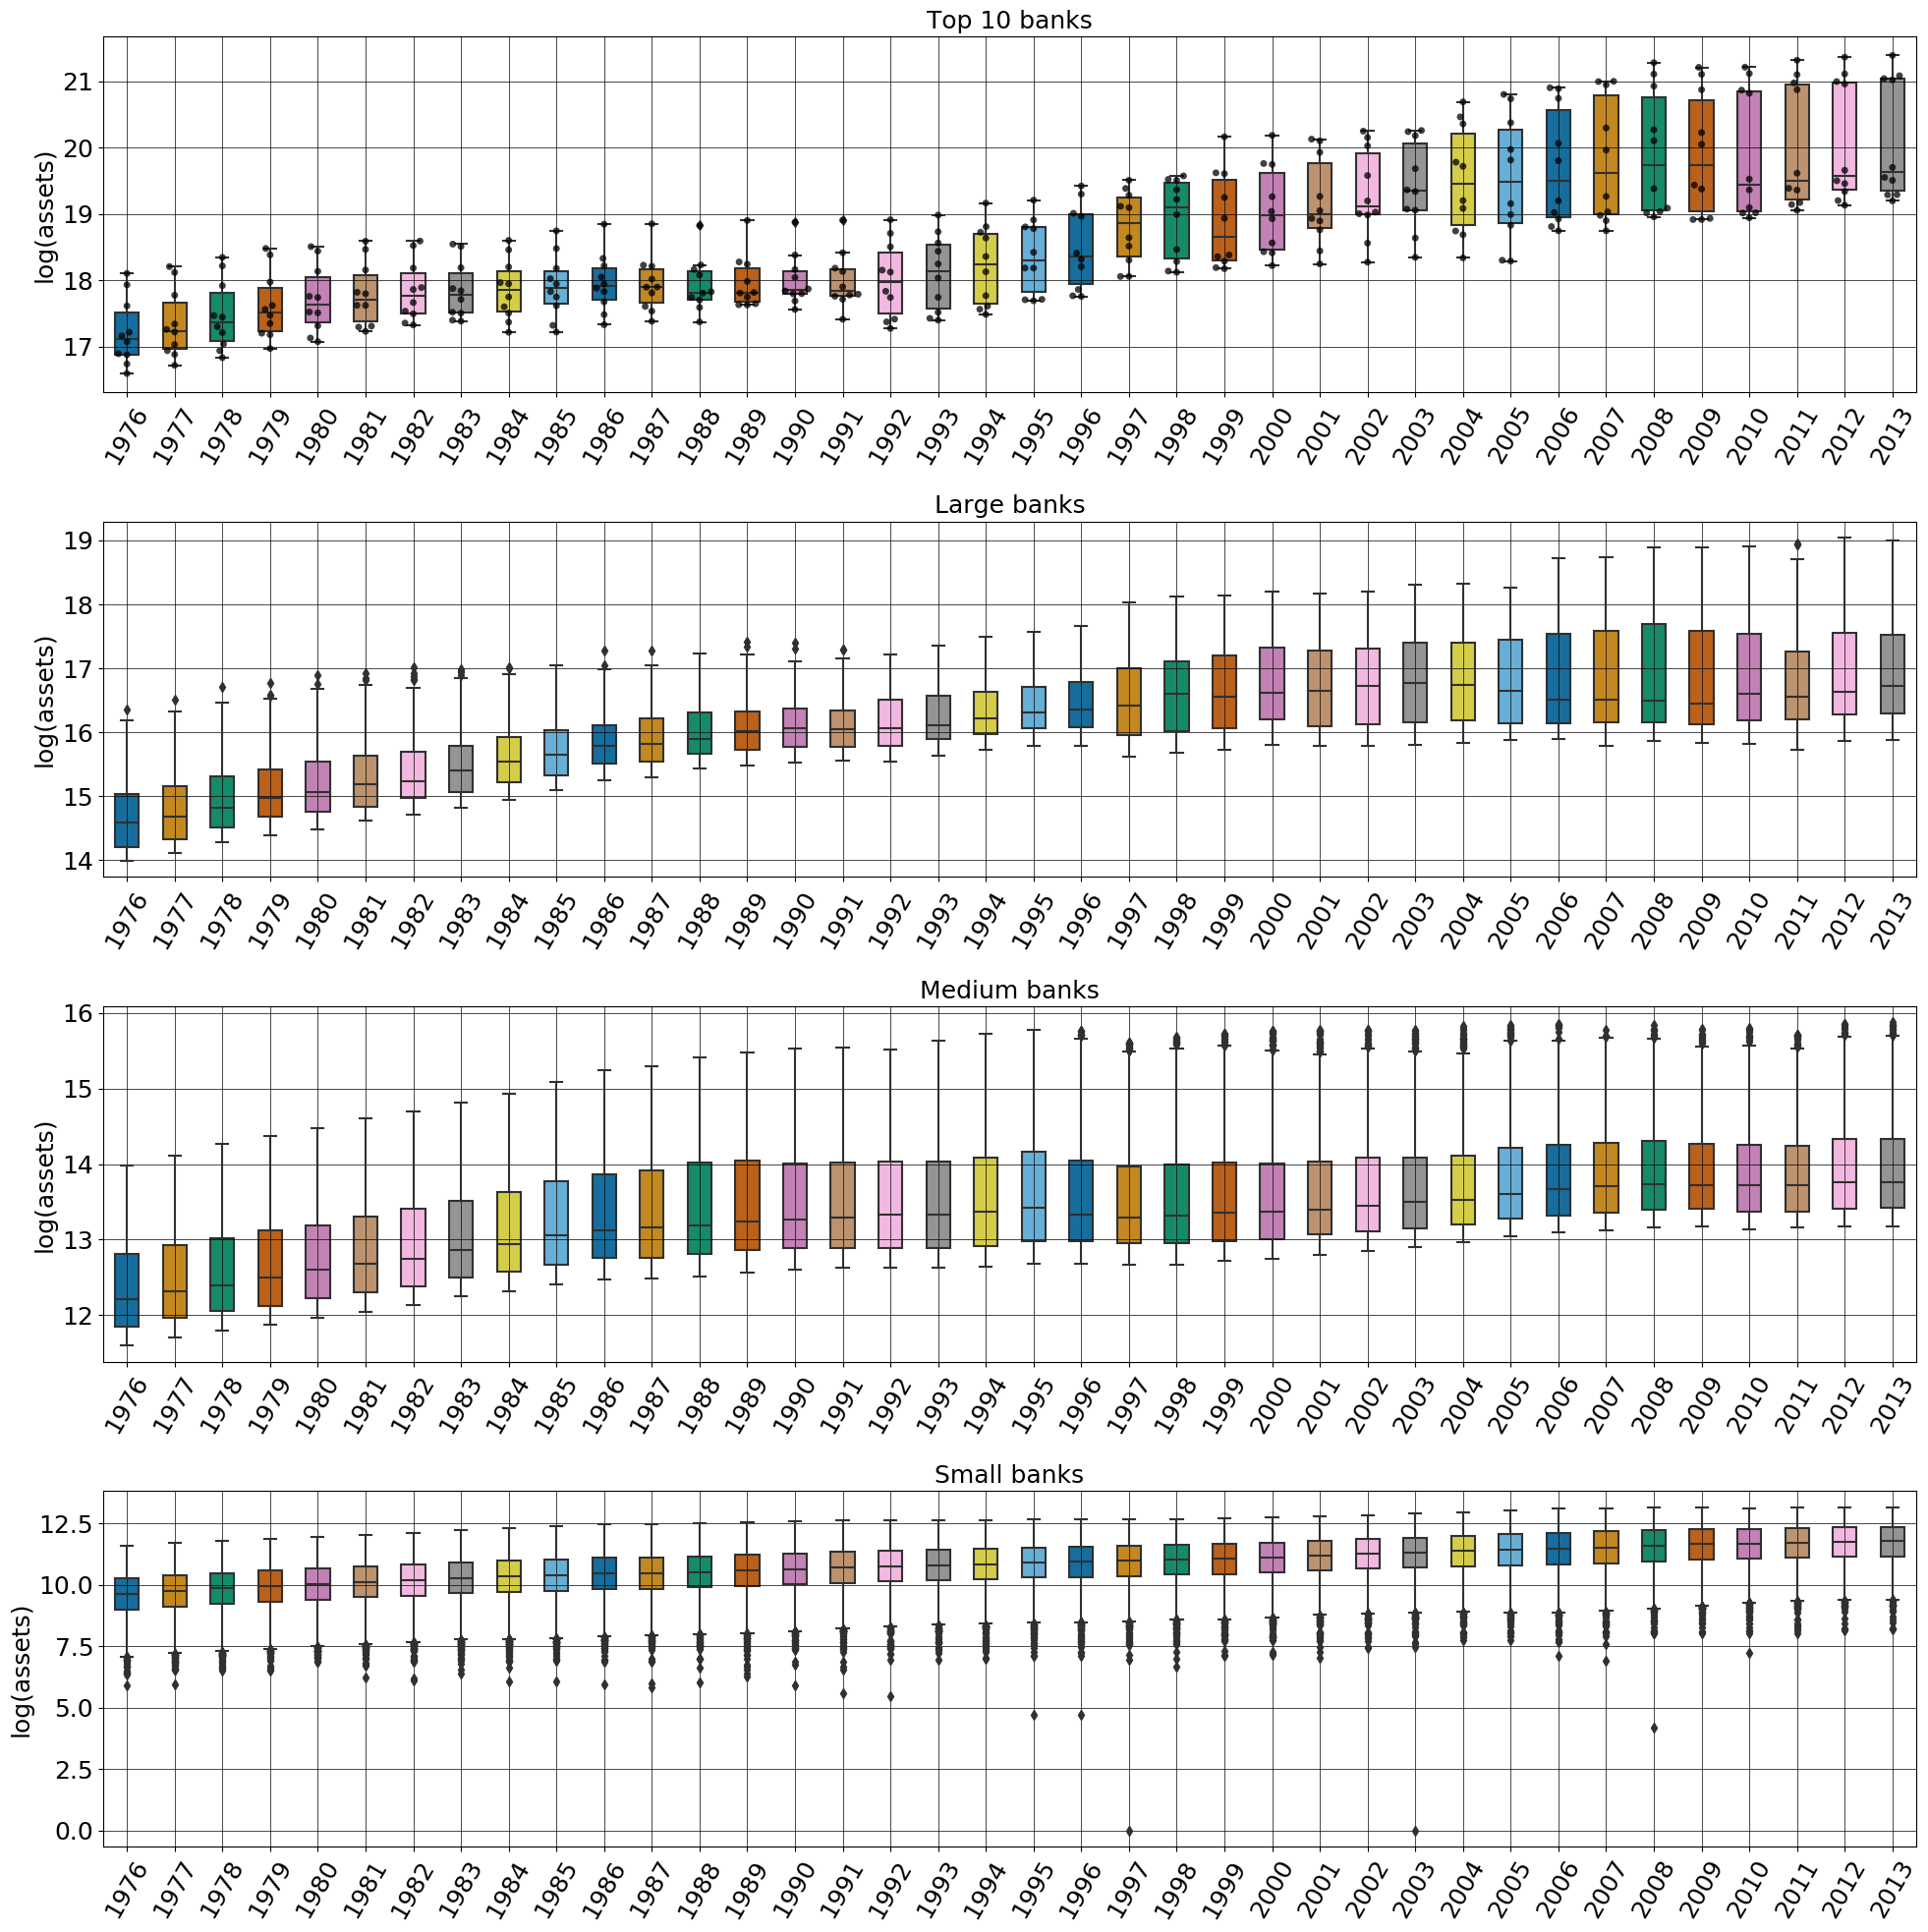

In [233]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(4,1,figsize=(20,20))
axes = ax.ravel()


# plot boxplot with seaborn
for i in range(4):
    bplot=sns.boxplot(ax=ax[i],x=array_cat_group_4[i].date, 
                      y=np.log(array_cat_group_4[i].assets),
                 width=0.5,
                 palette="colorblind")
    if (i < 1):
        bplot=sns.swarmplot(ax=ax[i], y=np.log(array_cat_group_4[i].assets), x=array_cat_group_4[i].date,
             
              color='black',
              alpha=0.75)
    ax[i].tick_params(axis="x", labelrotation=60)
    ax[i].set_ylabel("log(assets)")
    ax[i].set_xlabel("")
    ax[i].set_title(categories[i])
    ax[i].set_xticks(range(0,38))
    ax[i].set_xticklabels(years, rotation=60)
    #ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    #formatter = ticker.FormatStrFormatter(">%y<")
    #ax[i].xaxis.set_major_formatter(formatter)  
    ax[i].grid()

save("boxplots_eachCategory")

Growth rates

In [234]:
array_cats_asset_yearly = []

#Compute growth rates
for cat in array_cats_asset:
    df_temp = cat.resample("Y").last()
    df_temp["pct_change"] = df_temp.assets.pct_change()
    array_cats_asset_yearly.append(df_temp)


Plot assets by cat

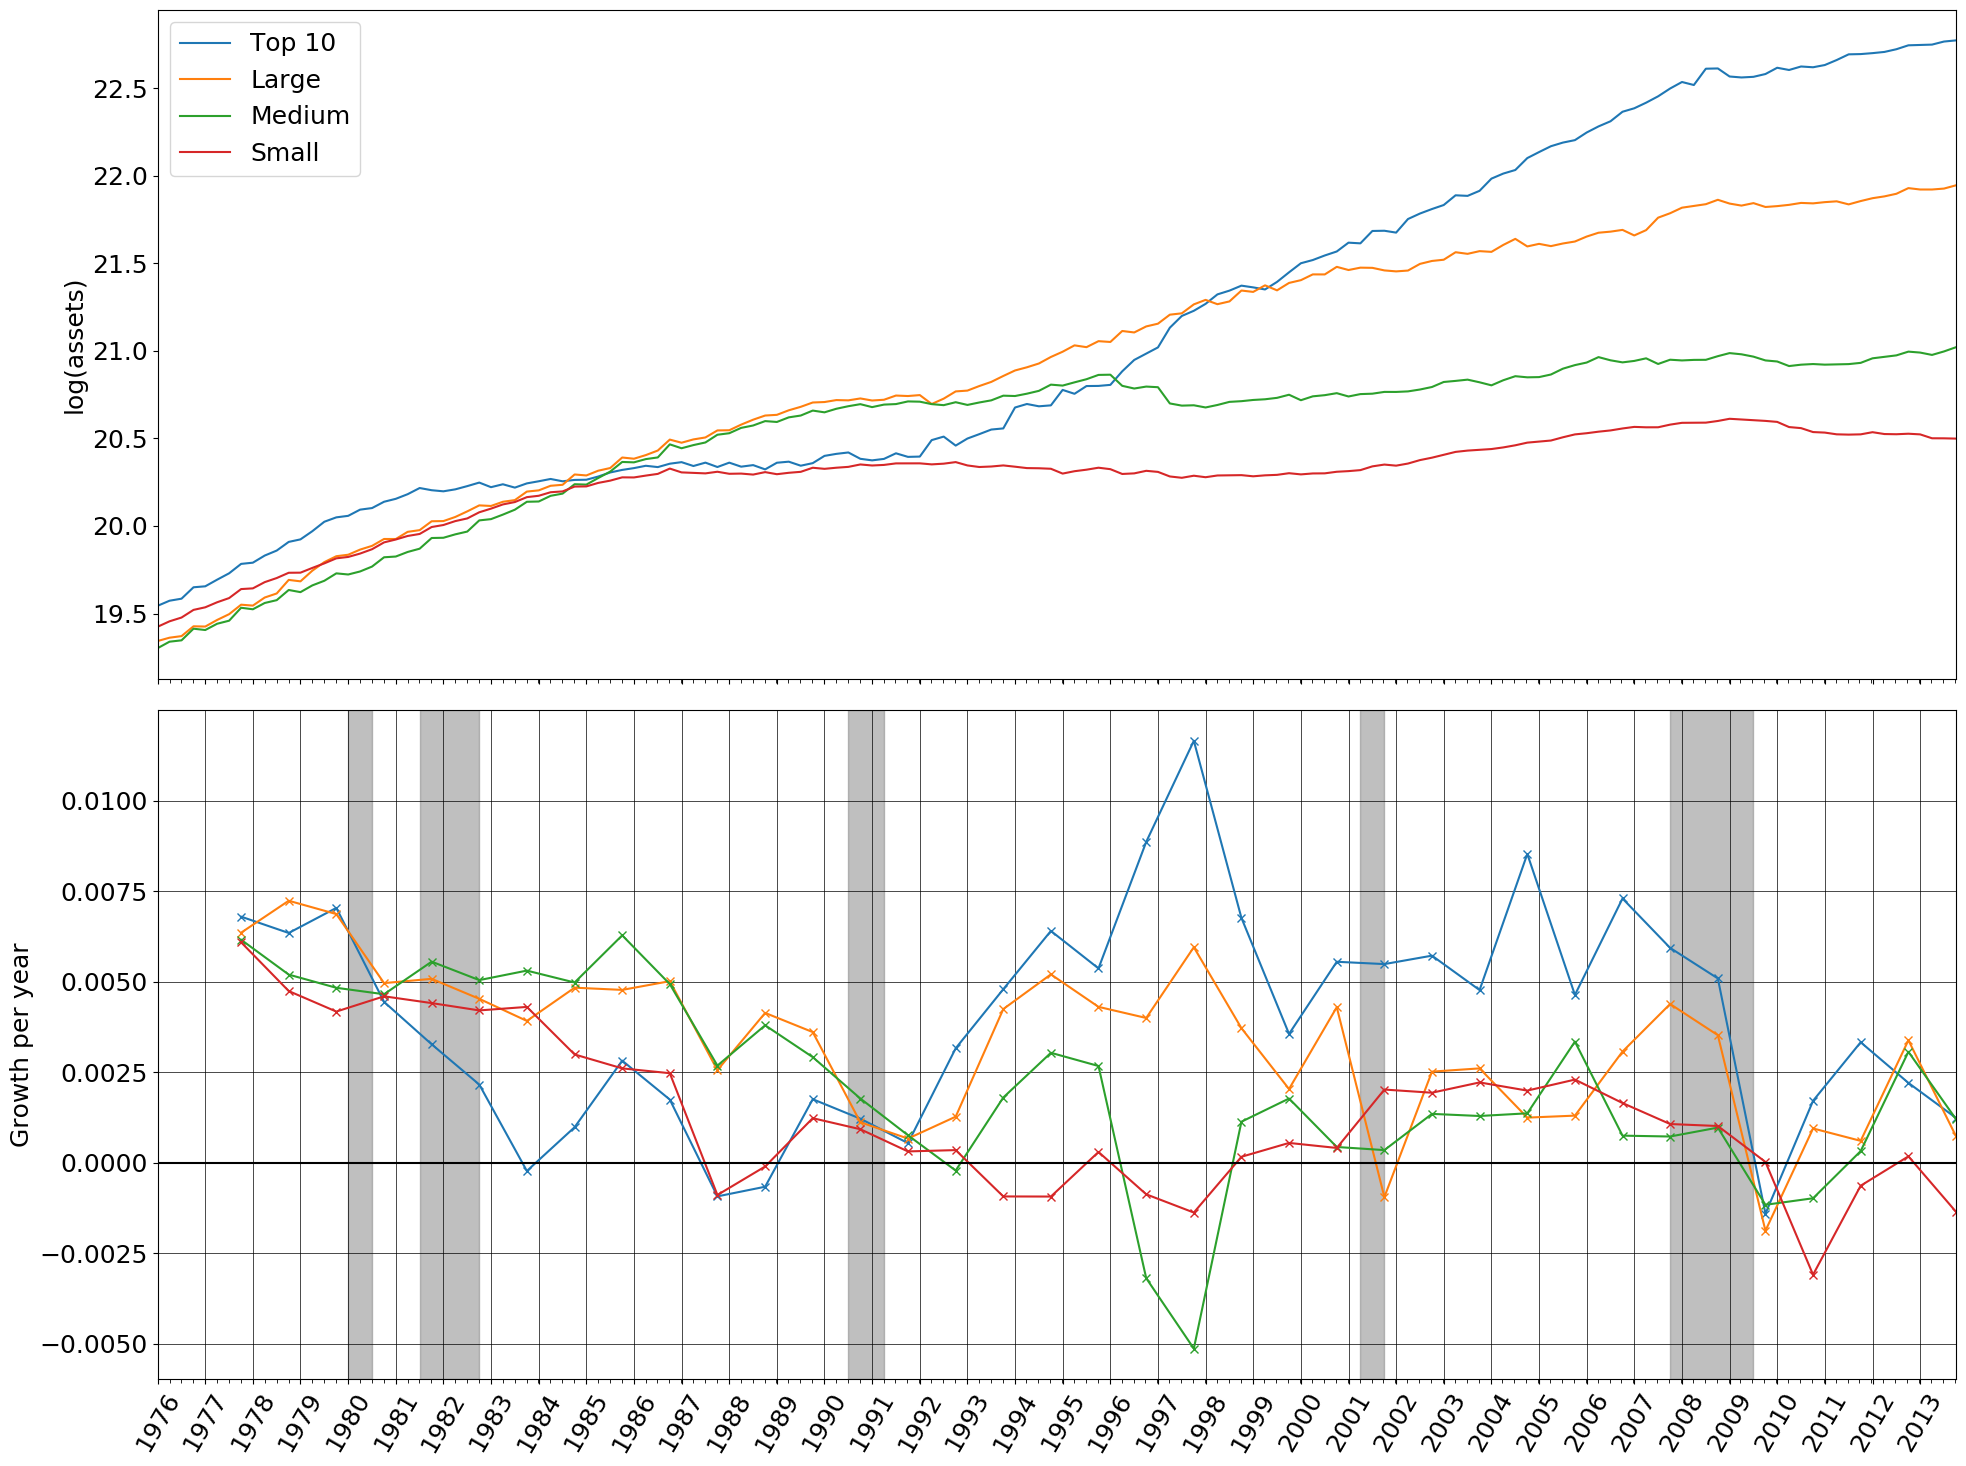

In [235]:
fig, ax = plt.subplots(2,1,figsize=(20,15), sharex=True)
ax = ax.ravel()

palette = itertools.cycle(sns.color_palette())

#Plot 1
for cat in array_cats_asset:
    ax[0].plot(cat.assets, color=next(palette))

    
catlegend(ax[0])
ax[0].set_ylabel("log(assets)")
#axsetting(ax[0])

palette = itertools.cycle(sns.color_palette())

#Plot 2
for cat in array_cats_asset_yearly:
    c = next(palette)
    ax[1].plot(cat["pct_change"] ,color=c)
    ax[1].plot(cat["pct_change"] ,"x", color=c)
    
ax[1].axhline(0, color="black")
axsetting(ax[1])


ax[1].set_ylabel("Growth per year")


#save
plt.tight_layout()
plt.savefig('LatexVorlage/graphs/DescriptiveStats/BanksByAssetCategory_assetsbycat_7613.png')

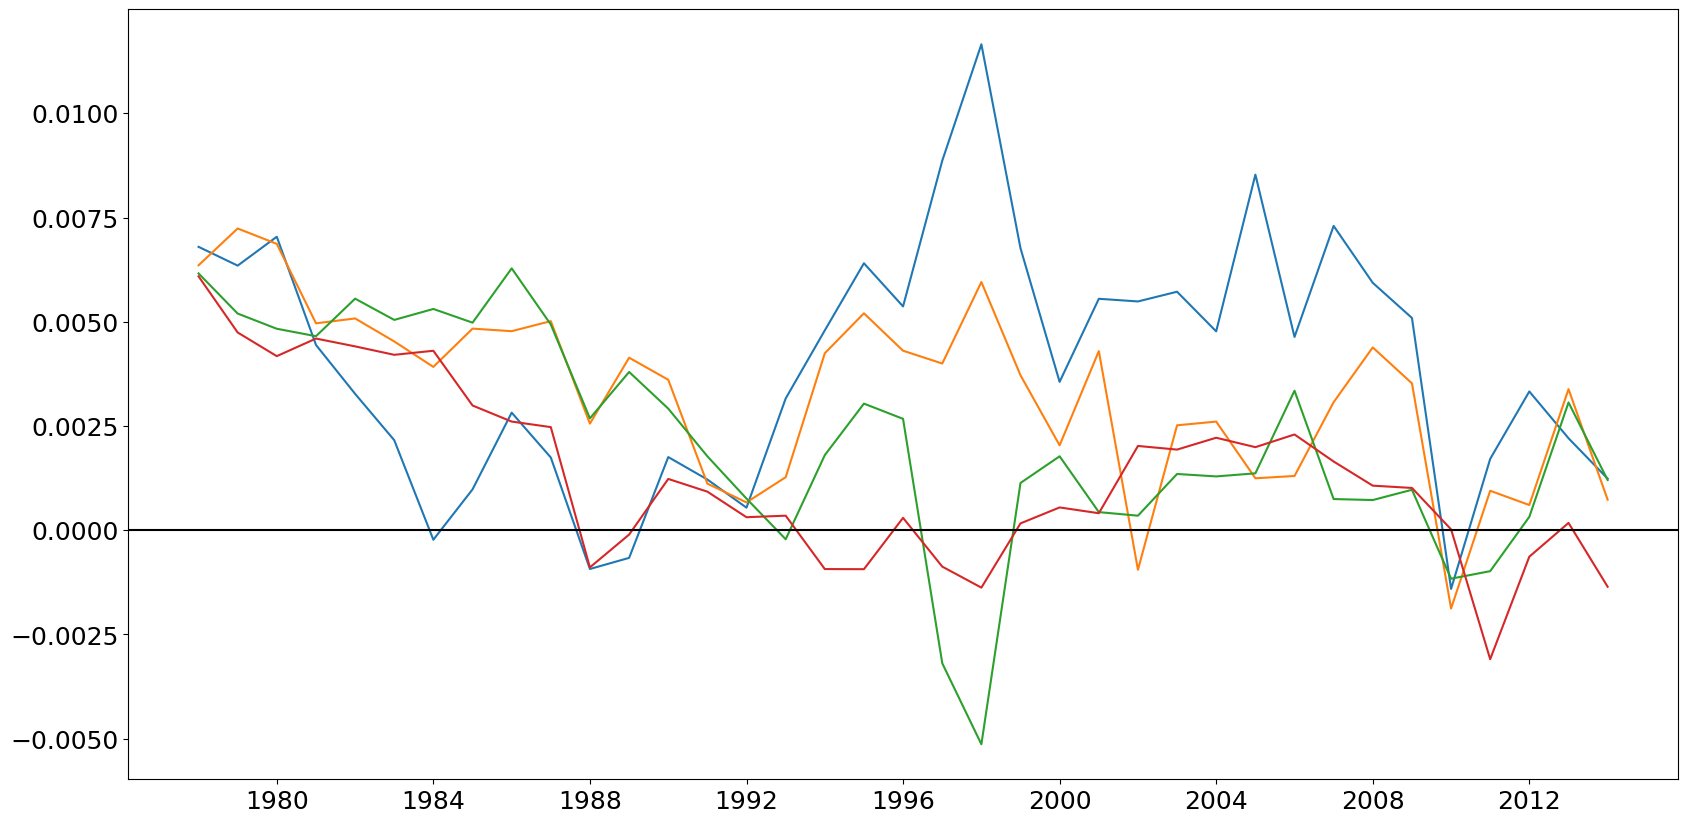

In [236]:
fig, ax = plt.subplots(figsize=figsize_OneGraph)

for cat in array_cats_asset_yearly:
    ax.plot(cat["pct_change"])
    
ax.axhline(0, color="black")

Cyclical assets

In [237]:
df_assets_cycle = pd.DataFrame()

#Compute cycle for cat
cycle, trend = sm.tsa.filters.hpfilter(df_agg_cat1_log.assets, 1600)
df_assets_cycle["cat1_assets"] = cycle
cycle, trend = sm.tsa.filters.hpfilter(df_agg_cat2_log.assets, 1600)
df_assets_cycle["cat2_assets"] = cycle
cycle, trend = sm.tsa.filters.hpfilter(df_agg_cat3_log.assets, 1600)
df_assets_cycle["cat3_assets"] = cycle
cycle, trend = sm.tsa.filters.hpfilter(df_agg_cat4_log.assets, 1600)
df_assets_cycle["cat4_assets"] = cycle


Standard Deviations

In [238]:
stds = df_assets_cycle.std().round(3)

(-9.550102975876769, 10.480691378183167)

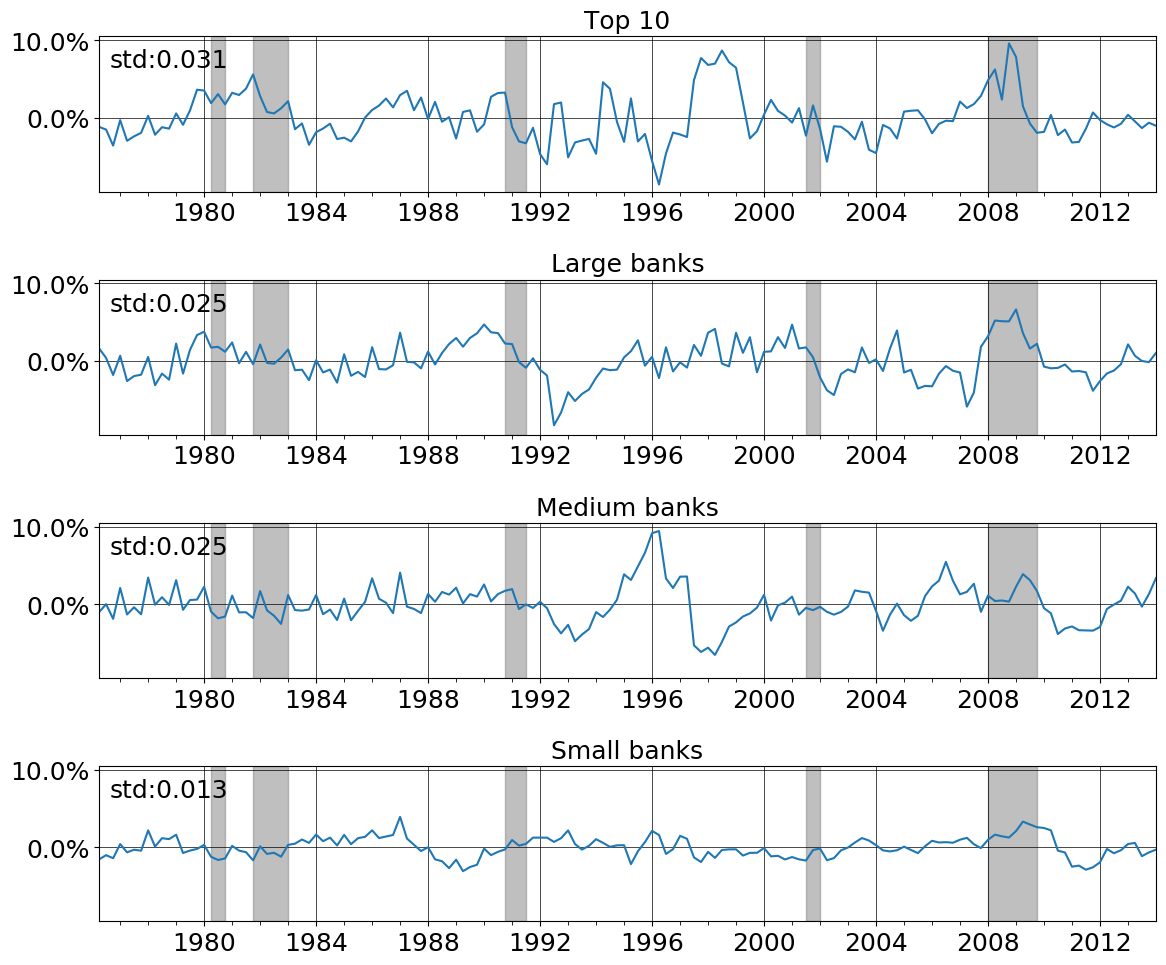

In [239]:
fig, ax = plt.subplots(4,1,figsize=(12,10), sharey=True )
ax = ax.ravel()



ax[0].set_title("Top 10")
ax[1].set_title("Large banks")
ax[2].set_title("Medium banks")
ax[3].set_title("Small banks")

axsetting2(ax[0])
axsetting2(ax[1])
axsetting2(ax[2])
axsetting2(ax[3])

ax[0].yaxis.set_major_formatter(ticker.PercentFormatter())
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter())
ax[2].yaxis.set_major_formatter(ticker.PercentFormatter())
ax[3].yaxis.set_major_formatter(ticker.PercentFormatter())


ax[0].plot(df_assets_cycle.cat1_assets*100)
ax[1].plot(df_assets_cycle.cat2_assets*100)
ax[2].plot(df_assets_cycle.cat3_assets*100)
ax[3].plot(df_assets_cycle.cat4_assets*100)

for i in range(4):
    ax[i].text(0.01,0.8,"std:" + str(stds.iloc[i]), transform=ax[i].transAxes)


save("catAssetsCycle")

ax[0].get_xlim()

ax[0].get_ylim()

Table cyclical numbers for crisis 2007/8

In [240]:
temp = df_assets_cycle[(df_assets_cycle.index>=("2006-12-31")) & 
                (df_assets_cycle.index<=("2011-12-31"))]

temp = temp *100

temp = temp.round(4)
temp.to_latex("LatexVorlage/graphs/Tables/LatexTables/cyclicalAssetsByCat_Crisis.tex")

Clean datasets for cyclical for other positions

In [241]:
def compute_cycle_trading(cat, column):
    #remove zeros
    temp_series = cat[column]
    temp_series.dropna(inplace=True)
    #comput cycle
    cycle, trend = sm.tsa.filters.hpfilter(temp_series, 1600)
    #insert zeros back into cycle
    count_missing_values = 152 - cycle.size
    zeros = pd.Series(np.zeros(count_missing_values))
    cycle = pd.concat([zeros, cycle])
    return cycle

Compute cyclical for each position

In [242]:
df_cycles = pd.DataFrame()
cat_counter = 1

for cat in array_cats:
    cat_columns = list(cat.iloc[:, 2:])
    for column in cat_columns:
        if (column.startswith("trading")):
            cycle = compute_cycle_trading(cat, column)
            df_cycles["cat" + str(cat_counter) + "_" + column] = cycle
        else:
            cycle, trend = sm.tsa.filters.hpfilter(cat[column], 1600)
            df_cycles["cat" + str(cat_counter) + "_" + column] = cycle
    cat_counter = cat_counter % 4
    cat_counter = cat_counter + 1    
        
        
cycle, trend = sm.tsa.filters.hpfilter(df_agg_cat1_log.assets, 1600)
df_assets_cycle["cat1_assets"] = cycle
cycle, trend = sm.tsa.filters.hpfilter(df_agg_cat2_log.assets, 1600)
df_assets_cycle["cat2_assets"] = cycle
cycle, trend = sm.tsa.filters.hpfilter(df_agg_cat3_log.assets, 1600)
df_assets_cycle["cat3_assets"] = cycle
cycle, trend = sm.tsa.filters.hpfilter(df_agg_cat4_log.assets, 1600)
df_assets_cycle["cat4_assets"] = cycle

Correlation between categories

Functions

In [243]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    pvalues = pvalues.astype("float")
    return pvalues

In [244]:
#apply color to significant values
def color_sig(val):
    
    color = 'royalblue' if val[-3:] == "***" else 'default'
    
    return 'background-color: %s' % color

In [245]:
pd.options.display.float_format = '{:.2}'.format

columns = df_agg_cat1_log.columns.values[0] 
temp_df = df_cycles.filter(like="_" + columns, axis=1)
pval = calculate_pvalues(temp_df)
temp_df_corr = temp_df.corr()
temp_df_corr = temp_df_corr.round(2)
#create three masks
r1 = temp_df_corr.applymap(lambda x: '{}*'.format(x))
r2 = temp_df_corr.applymap(lambda x: '{}**'.format(x))
r3 = temp_df_corr.applymap(lambda x: '{}***'.format(x))
    
# apply them where appropriate
temp_df_corr = temp_df_corr.mask(pval<=0.1,r1)
temp_df_corr = temp_df_corr.mask(pval<=0.05,r2)
temp_df_corr = temp_df_corr.mask(pval<=0.01,r3)
    
temp_df_corr = temp_df_corr.astype("str")

temp_df_corr.style.applymap(color_sig)
    

In [246]:
pd.options.display.float_format = '{:.2}'.format

for columns in df_agg_cat1_log.columns.values:
    temp_df = df_cycles.filter(like="_" + columns, axis=1)
    pval = calculate_pvalues(temp_df)
    temp_df_corr = temp_df.corr()
    temp_df_corr = temp_df_corr.round(2)
    #create three masks
    r1 = temp_df_corr.applymap(lambda x: '{}*'.format(x))
    r2 = temp_df_corr.applymap(lambda x: '{}**'.format(x))
    r3 = temp_df_corr.applymap(lambda x: '{}***'.format(x))
    
    # apply them where appropriate
    temp_df_corr = temp_df_corr.mask(pval<=0.1,r1)
    temp_df_corr = temp_df_corr.mask(pval<=0.05,r2)
    temp_df_corr = temp_df_corr.mask(pval<=0.01,r3)
    
    temp_df_corr = temp_df_corr.astype("str")
    
    print(columns)
    
    if ( (str(columns) != "year") & (str(columns) != "quarter")):
        temp_df_corr.to_latex("LatexVorlage/graphs/Tables/LatexTables/cat_" + str(columns) + "_cycle_corr.tex")

    temp_df_corr.style.applymap(color_sig)
    
    

year
quarter
assets
cash
fedfundsrepoasset
securities
loansnet
tradingassets
otherassets


Further look into correlation between cat1 and cat3

In [247]:
#choose my categories
temp_df_cycles = df_cycles.copy()

#datetimes to drop
start_remove = pd.to_datetime('1996-03-31')
end_remove = pd.to_datetime('1999-12-31')
temp_df_cycles = temp_df_cycles.loc[(temp_df_cycles.index < start_remove) | (temp_df_cycles.index > end_remove)]

temp_df_cycles["cat1_assets"].corr(temp_df_cycles["cat3_assets"])

df_cycles["cat1_assets"].corr(df_cycles["cat3_assets"])

-0.2673416437939859

Compute correlation per position

Assets

In [248]:
df_cycles_assets = df_cycles.filter(like="_" + "assets", axis=1)

Cross-Autocorrelations

In [249]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

In [250]:
temp_df = pd.DataFrame()
for column1 in df_cycles_assets:
    for column2 in df_cycles_assets:
        temp_array = []
        for i in range(10):
            temp_array.append(crosscorr(df_assets_cycle[column1], df_assets_cycle[column2], i))
        temp_df[column1 + "+" + column2] = temp_array
        
temp_df.index.rename("lag", inplace=True)

for i in range(0,16,4):
    temp_df.iloc[:,i:i+4]
    


Median banks per category

In [251]:
def get_cat(gr, cat):
    global df_cat1_banks
    global df_cat2_banks
    global df_cat3_banks
    global df_cat4_banks
    if cat == 1:
        return gr.iloc[:10,:]
    elif cat == 2:
        return gr.iloc[10:100,:]
    elif cat == 3:
        return gr.iloc[100:1000,:]
    elif cat == 4:
        return gr.iloc[1000:,:]

In [252]:
array_cat_median = [pd.Series(), pd.Series(), pd.Series(), pd.Series()]

grouped = df_assets.groupby(["date"])

for i in range(1,5):
    for name, gr in grouped:
        gr = gr.sort_values(by="assets", ascending=False)
        gr = get_cat(gr,i)
        #get median
        median = {name : gr.assets.median()}
        temp_s = pd.Series(median)
        #add to minmax dataframe
        array_cat_median[i-1] =  array_cat_median[i-1].append(temp_s)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


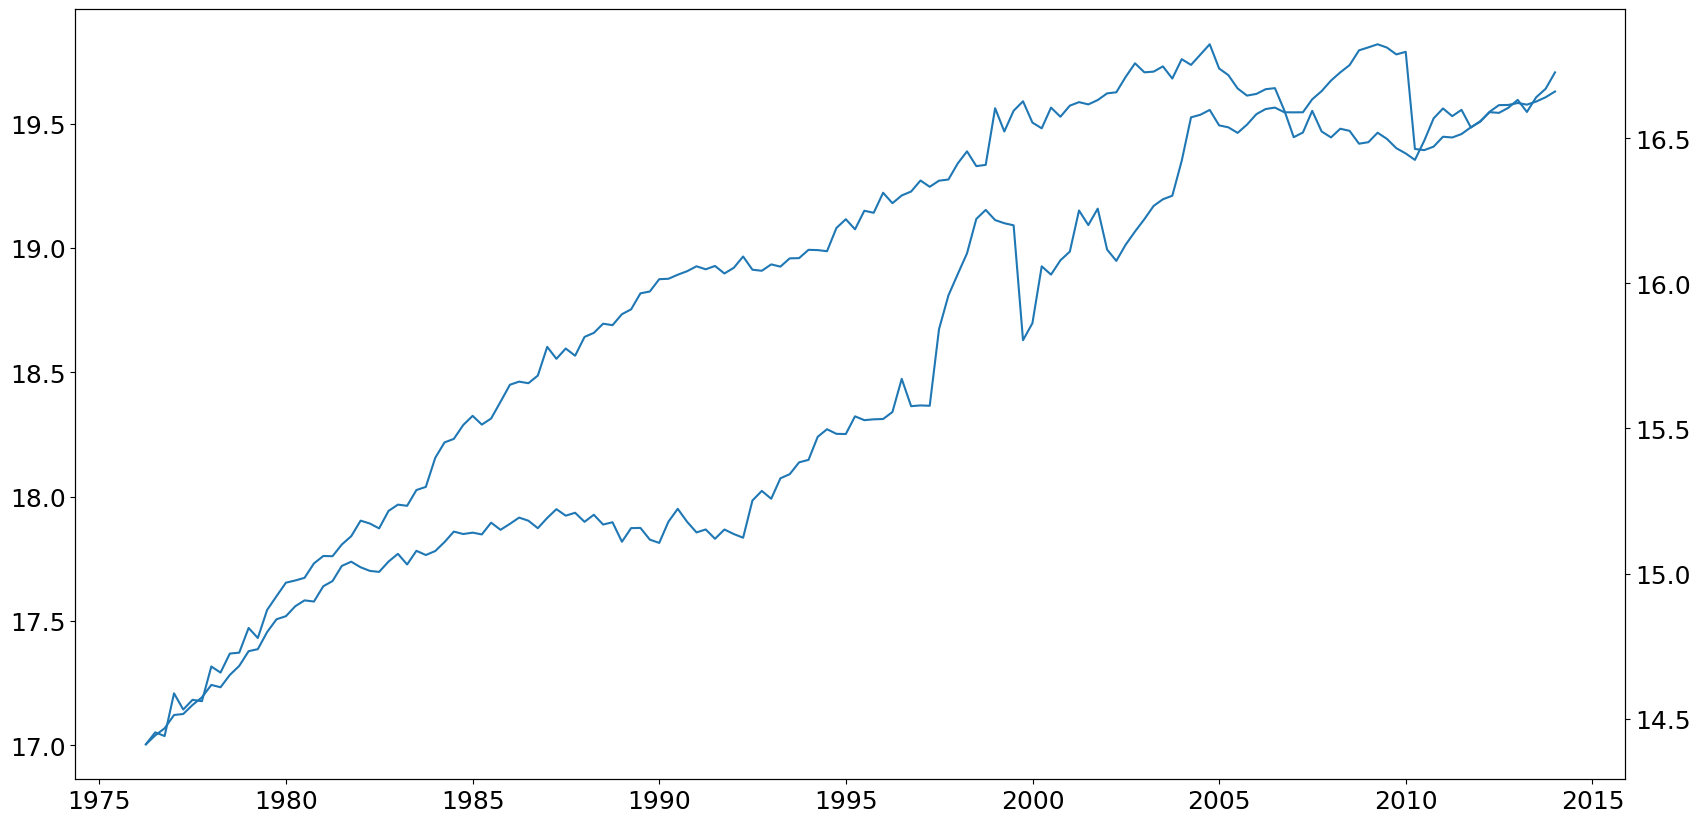

In [253]:
fig, ax = plt.subplots(figsize=figsize_OneGraph)

ax.plot(np.log(array_cat_median[0]))

ax1 = ax.twinx()

ax1.plot(np.log(array_cat_median[1]))

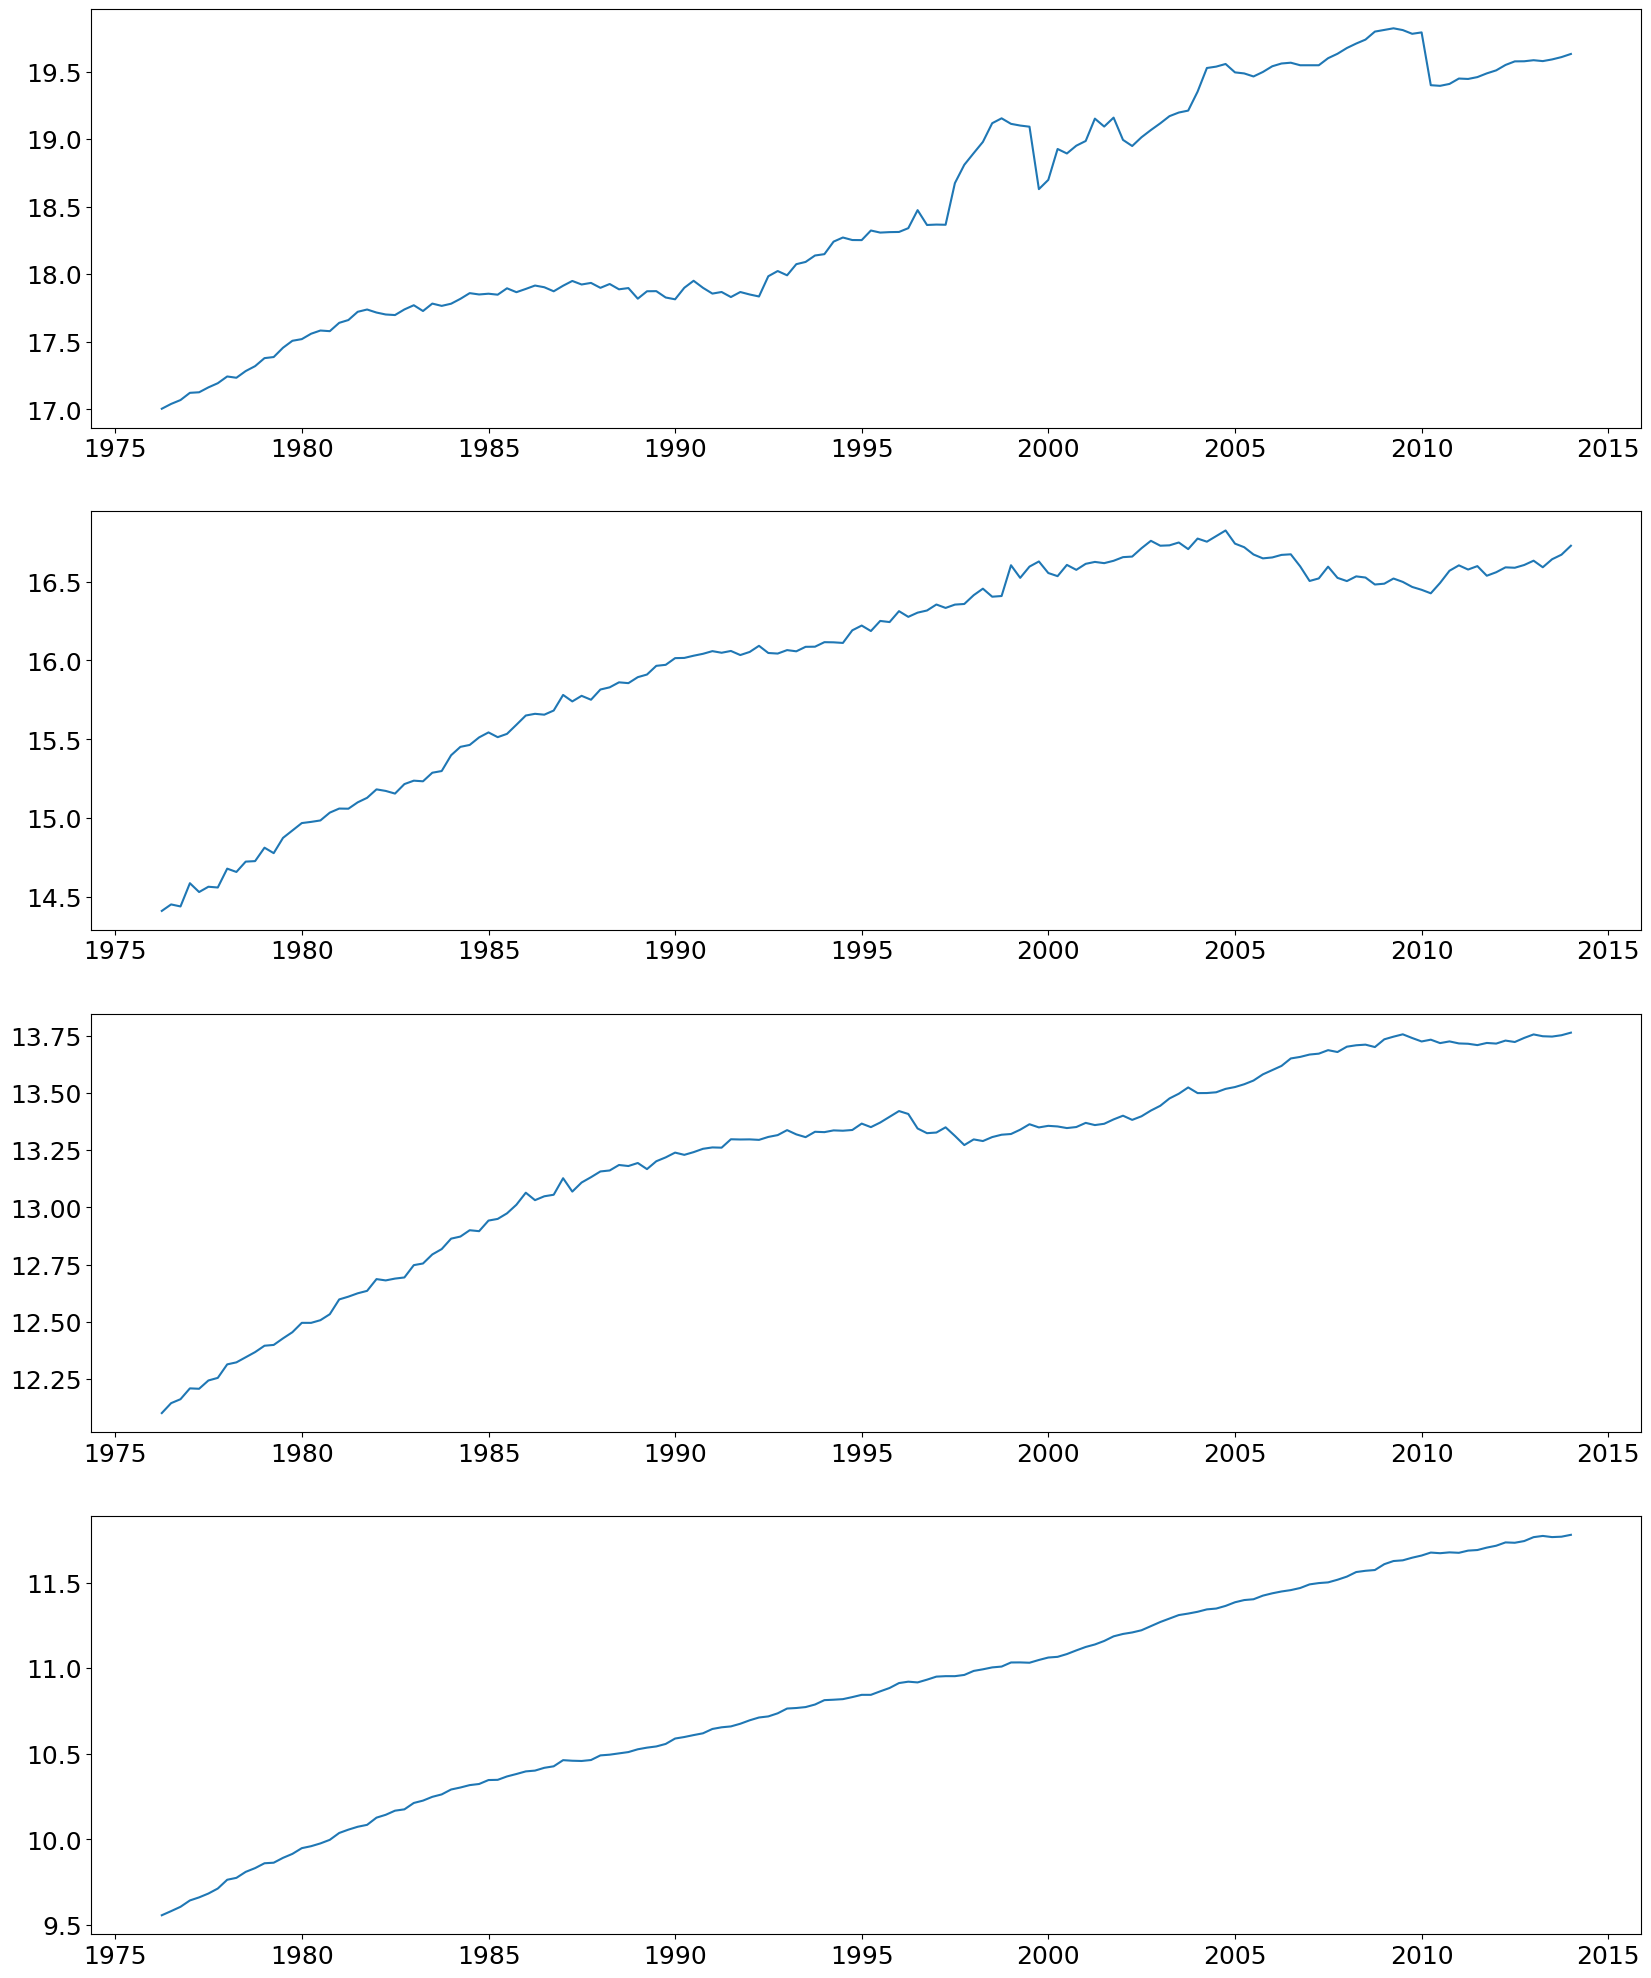

In [254]:
fig, ax = plt.subplots(4,1,figsize=(20,25))
ax = ax.ravel()

for i in range(4):
    ax[i].plot(np.log(array_cat_median[i]))

Share by position

Assets

In [255]:


# arrays to save share

array_assets_share = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
array_liabs_share = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

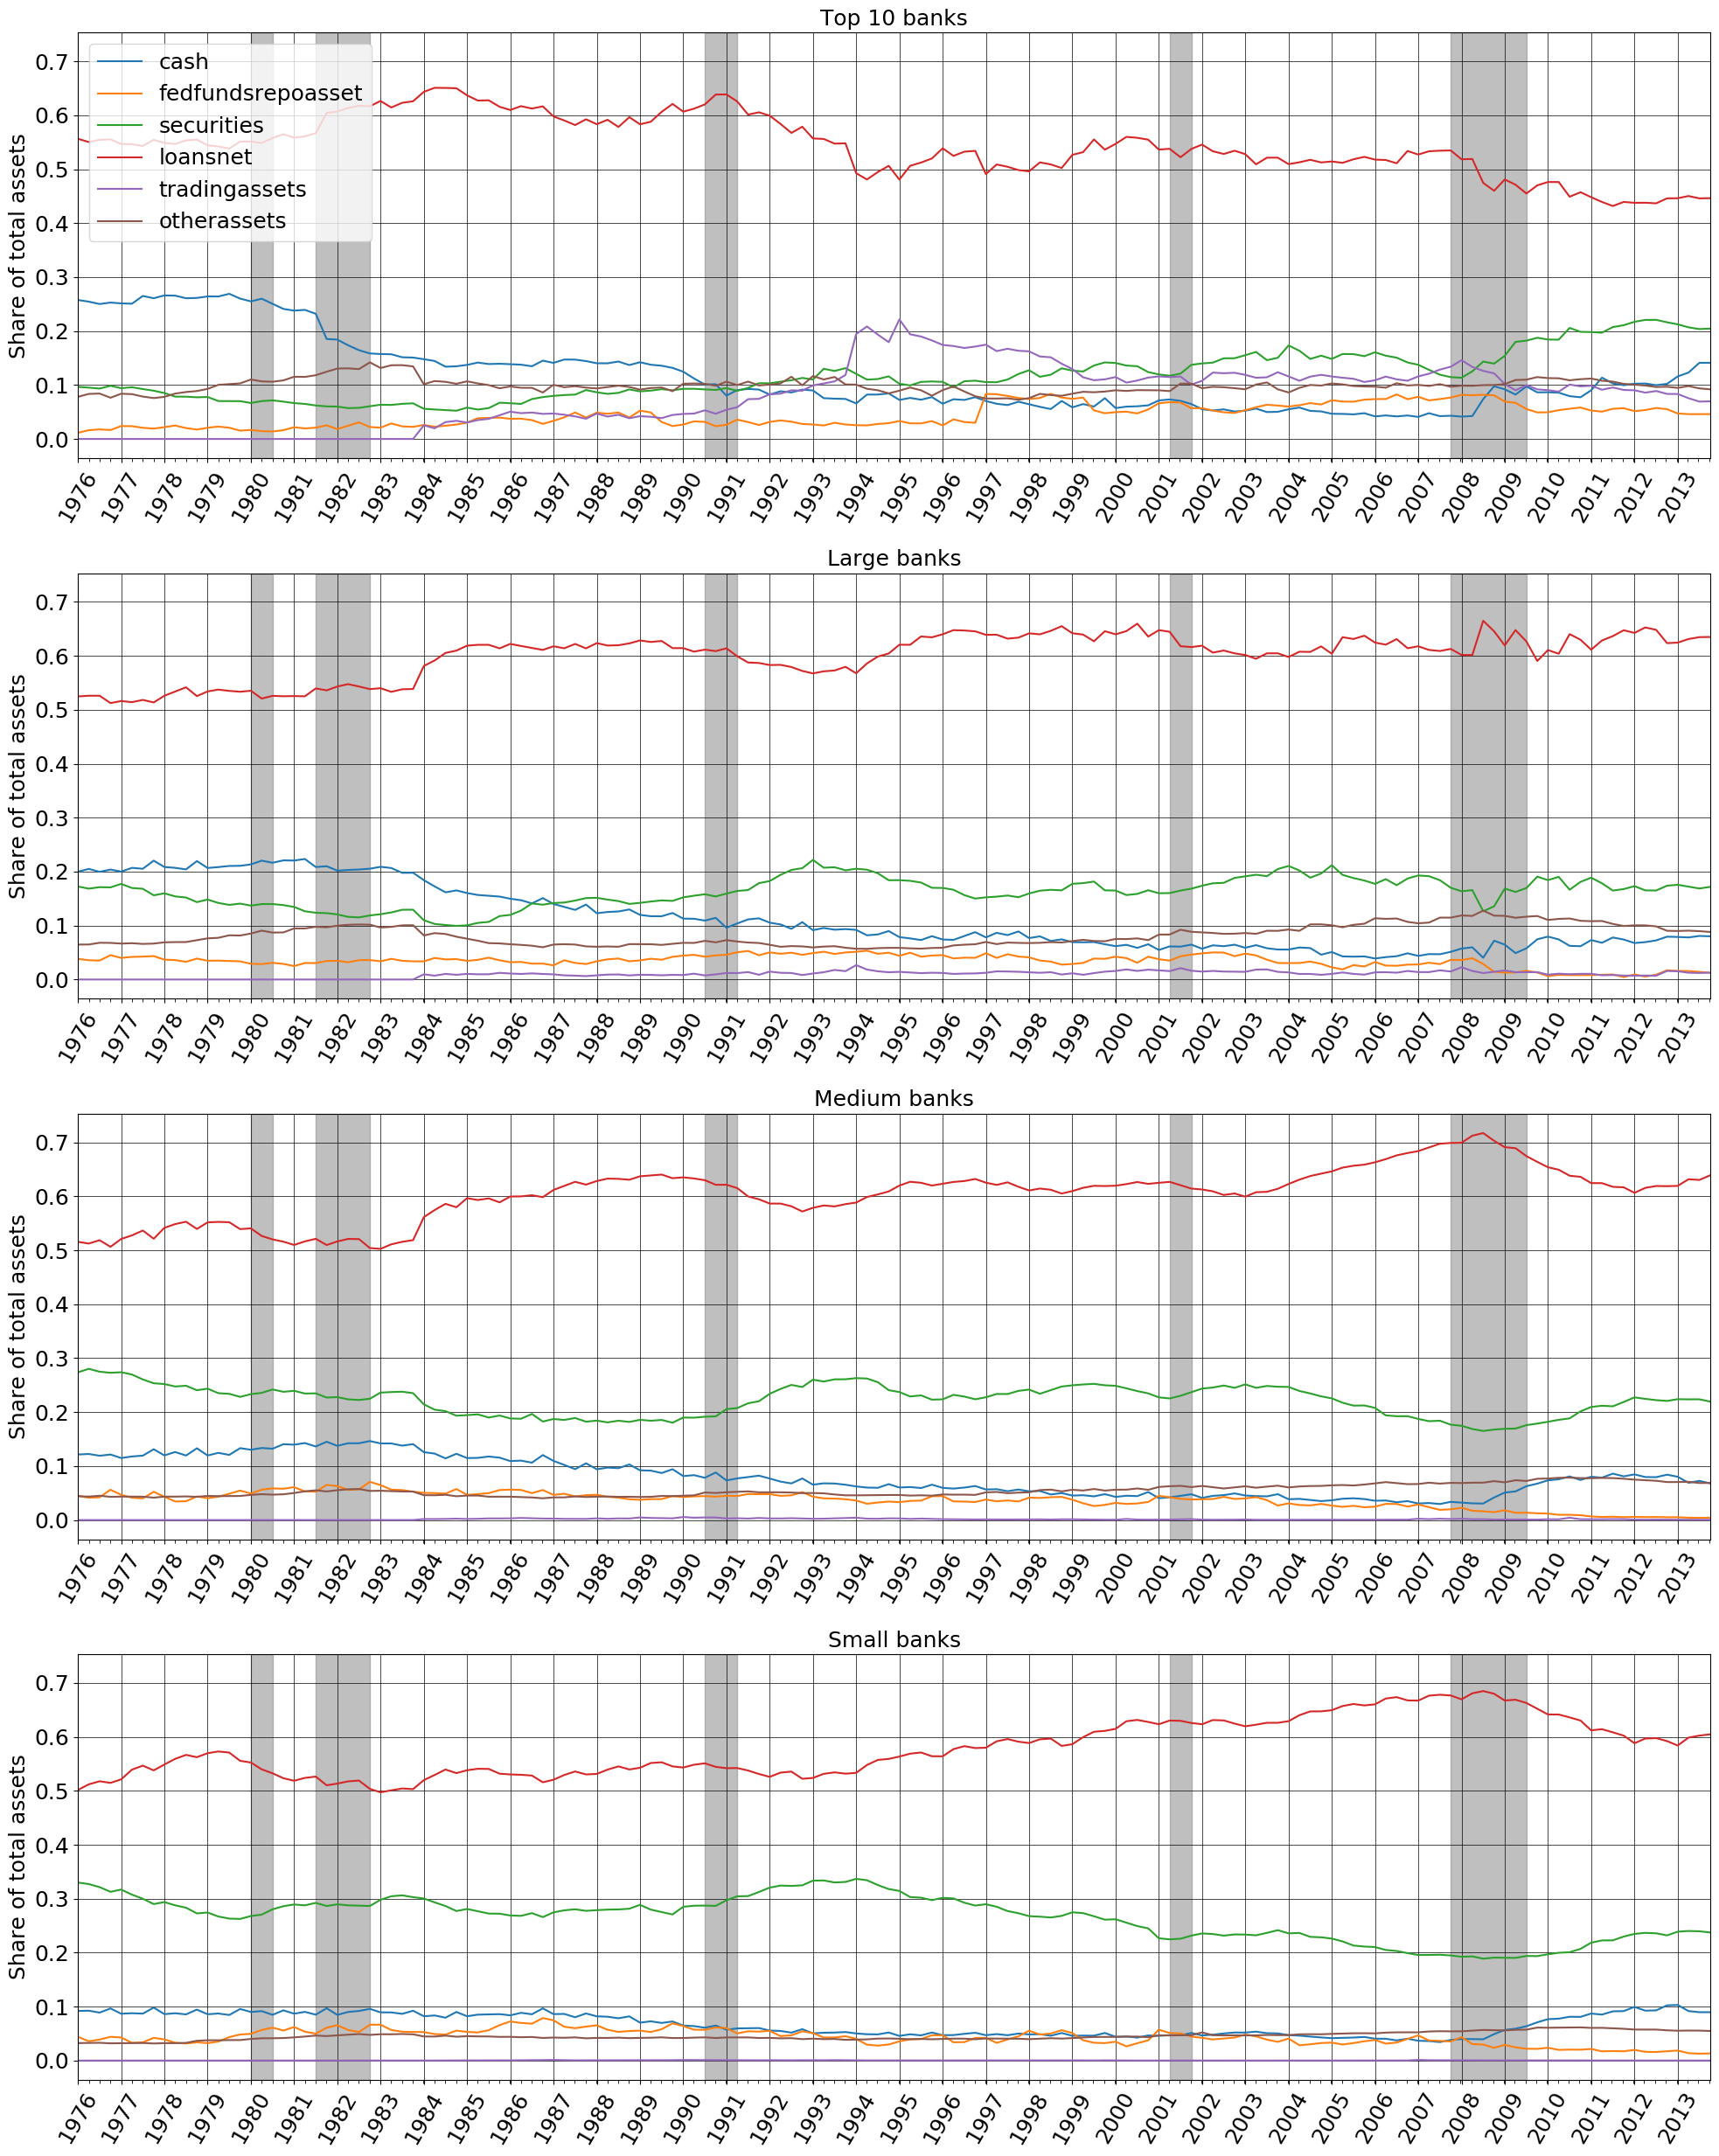

In [256]:
fig, ax = plt.subplots(4,1,figsize=(20,25), sharey=True)
ax = ax.ravel()



for i in range(4):
    columns = array_cats_asset_raw[i].iloc[:,3:].columns.values
    for column in columns:
        #compute share
        temp_share = array_cats_asset_raw[i][column]/array_cats_asset_raw[i].assets
        #save share
        array_assets_share[i][column] = temp_share
        #plot share
        ax[i].plot(temp_share)
    #ax[i].legend(columns, loc="upper left") 
    ax[i].set_title(categories[i])
    ax[i].set_ylabel("Share of total assets")
    axsetting(ax[i])
    

ax[0].legend(columns, loc="upper left")

save("cat_assets_share")

Liabs

In [257]:
array_cats_liab_raw[0].columns

Index(['year', 'quarter', 'assets', 'equity', 'fedfundsrepoliab', 'deposits', 'foreigndep', 'otherborrowedmoney', 'tradingliabilities', 'subordinateddebt', 'otherliab'], dtype='object')

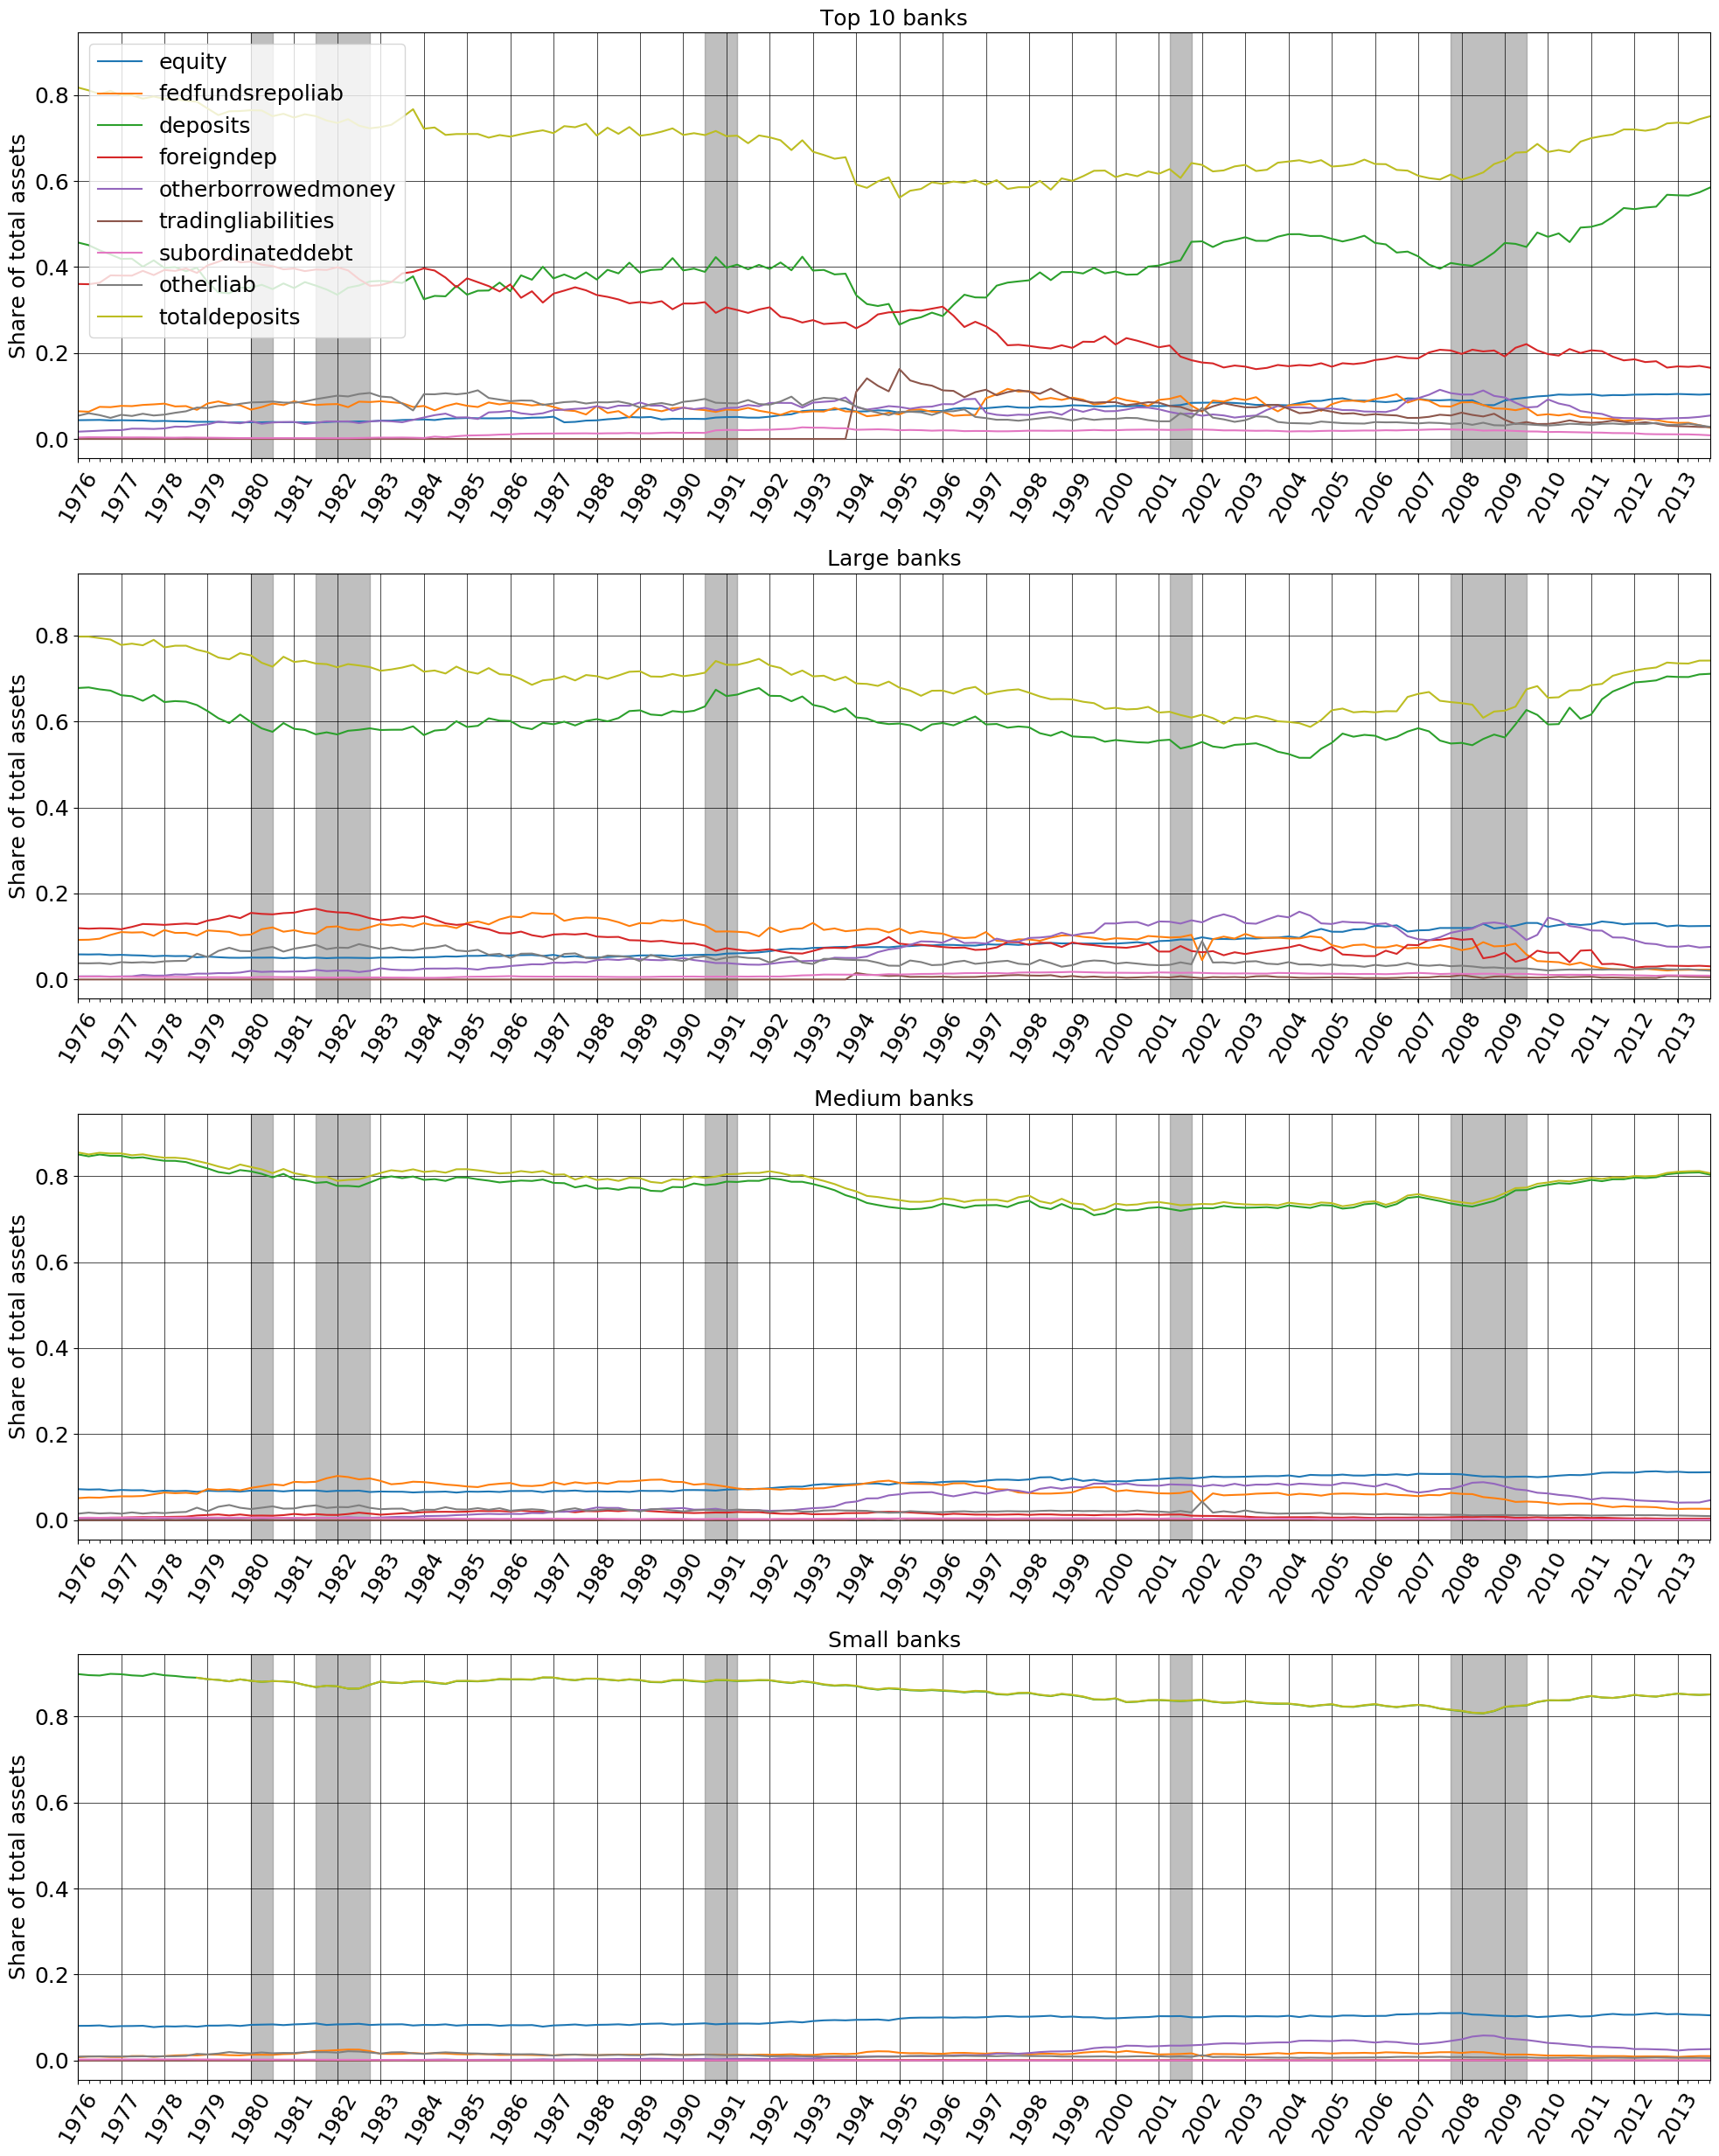

In [258]:
fig, ax = plt.subplots(4,1,figsize=(20,25), sharey=True)
ax = ax.ravel()

#array_cats_asset_raw


for i in range(4):
    columns = array_cats_liab_raw[i].iloc[:,3:].columns.values
    for column in columns:
            temp_share = array_cats_liab_raw[i][column]/array_cats_liab_raw[i].assets
            array_liabs_share[i][column] = temp_share
            ax[i].plot(temp_share)
    #ax[i].legend(columns, loc="upper left")
    ax[i].set_title(categories[i])
    ax[i].set_ylabel("Share of total assets")
    axsetting(ax[i])
 
for j in range(len(array_liabs_share)):
    array_liabs_share[j]["totaldeposits"] = array_liabs_share[j].deposits + array_liabs_share[j].foreigndep
    ax[j].plot(array_liabs_share[j]["totaldeposits"])
    #columns = np.append(columns, "totaldeposits")
    #ax[j].legend(columns, loc="upper left")
    
columns = np.append(columns, "totaldeposits")
ax[0].legend(columns, loc="upper left")
    
save("cat_liabs_share")

In [259]:
for df_share in array_assets_share:
    df_share.corr()

In [260]:
for df_share in array_liabs_share:
    df_share.corr()

Leverage by category

Scatterplot: Average Leverage

In [261]:
categories = ["Top 10 banks", "Large banks", "Medium banks", "Small banks"]

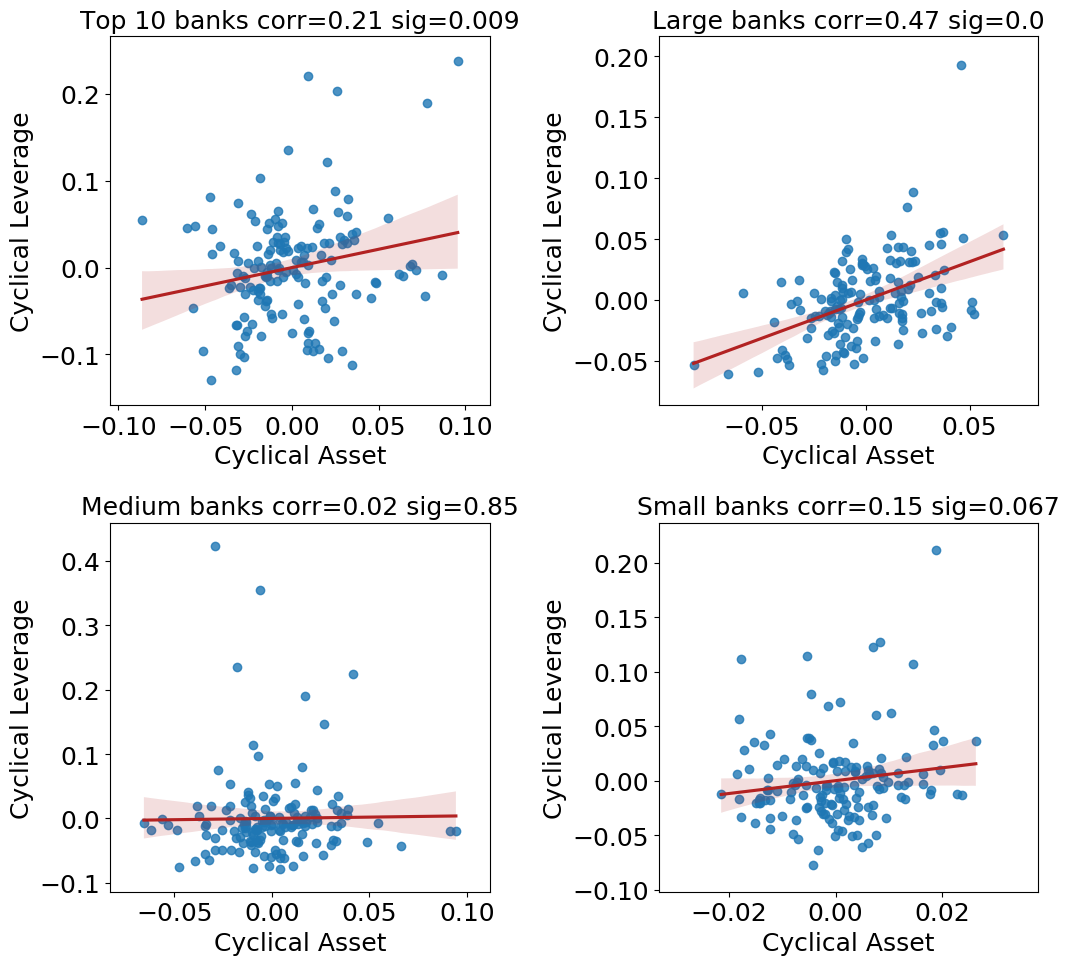

In [262]:
for cat in array_cat_group_liab:
    cat["leverage"] = cat.assets/cat.equity

for x in range(len(array_cat_group_liab)):
    array_cat_group_liab[x] = array_cat_group_liab[x][array_cat_group_liab[x].leverage > 0]

for cat in array_cat_group_liab:
    cat.leverage.replace([np.inf, -np.inf], np.nan, inplace=True)
    cat.dropna(how="all", subset=["leverage"], inplace=True)
    
array_cats_liab_raw_mean = []
array_cats_liab_raw_sum = []
    
for cat in array_cat_group_liab:
    copy = cat.copy()
    copy1 = cat.copy()
    array_cats_liab_raw_mean.append(copy.groupby("date").mean())
    array_cats_liab_raw_sum.append(copy1.groupby("date").sum())

    
fig, ax = plt.subplots(2,2, figsize=(11,10))
ax = ax.ravel()

count_cat = 4

for i in range(count_cat):
    cycle_leverage1, trend_leverage = sm.tsa.filters.hpfilter(np.log(array_cats_liab_raw_mean[i].leverage), 1600)
    
    cycle_assets1, trend_leverage = sm.tsa.filters.hpfilter(np.log(array_cats_liab_raw_mean[i].assets), 1600)
    
    sns.regplot(x=cycle_assets1, y=cycle_leverage1, ax=ax[i], line_kws={"color":'firebrick'})
    
    tuple_corr = scipy.pearsonr(cycle_leverage1, cycle_assets1)
    
    ax[i].set_title(categories[i] +  " corr=" + str(tuple_corr[0].round(2)) + " sig=" + str(tuple_corr[1].round(3)))
    
    ax[i].set_ylabel("Cyclical Leverage")
    
    ax[i].set_xlabel("Cyclical Asset")

    
#array_cats_liab_raw_mean
    
plt.tight_layout()
plt.savefig('LatexVorlage/graphs/DescriptiveStats/BanksbyAssetsCategory_ScatterAverageLeveragevsAverageAssetsCat_7613.png')

In [263]:
array_cats_liab_raw_sum[3].assets

date
1976-03-31   2.7e+08
1976-06-30   2.8e+08
1976-09-30   2.9e+08
1976-12-31     3e+08
1977-03-31     3e+08
1977-06-30   3.1e+08
1977-09-30   3.2e+08
1977-12-31   3.4e+08
1978-03-31   3.4e+08
1978-06-30   3.5e+08
1978-09-30   3.6e+08
1978-12-31   3.7e+08
1979-03-31   3.7e+08
1979-06-30   3.8e+08
1979-09-30   3.9e+08
1979-12-31     4e+08
1980-03-31   4.1e+08
1980-06-30   4.1e+08
1980-09-30   4.2e+08
1980-12-31   4.4e+08
1981-03-31   4.5e+08
1981-06-30   4.6e+08
1981-09-30   4.6e+08
1981-12-31   4.8e+08
1982-03-31   4.9e+08
1982-06-30     5e+08
1982-09-30   5.1e+08
1982-12-31   5.2e+08
1983-03-31   5.4e+08
1983-06-30   5.5e+08
1983-09-30   5.6e+08
1983-12-31   5.7e+08
1984-03-31   5.8e+08
1984-06-30   5.9e+08
1984-09-30   5.9e+08
1984-12-31   6.1e+08
1985-03-31   6.1e+08
1985-06-30   6.2e+08
1985-09-30   6.3e+08
1985-12-31   6.4e+08
1986-03-31   6.4e+08
1986-06-30   6.5e+08
1986-09-30   6.5e+08
1986-12-31   6.7e+08
1987-03-31   6.6e+08
1987-06-30   6.6e+08
1987-09-30   6.5e+08
1987-12-

In [264]:
array_cats_liab_raw_mean[3].assets

date
1976-03-31     2e+04
1976-06-30   2.1e+04
1976-09-30   2.1e+04
1976-12-31   2.2e+04
1977-03-31   2.3e+04
1977-06-30   2.3e+04
1977-09-30   2.4e+04
1977-12-31   2.5e+04
1978-03-31   2.5e+04
1978-06-30   2.6e+04
1978-09-30   2.7e+04
1978-12-31   2.8e+04
1979-03-31   2.8e+04
1979-06-30   2.9e+04
1979-09-30   2.9e+04
1979-12-31     3e+04
1980-03-31     3e+04
1980-06-30   3.1e+04
1980-09-30   3.2e+04
1980-12-31   3.3e+04
1981-03-31   3.3e+04
1981-06-30   3.4e+04
1981-09-30   3.5e+04
1981-12-31   3.6e+04
1982-03-31   3.6e+04
1982-06-30   3.7e+04
1982-09-30   3.8e+04
1982-12-31   3.9e+04
1983-03-31     4e+04
1983-06-30   4.1e+04
1983-09-30   4.1e+04
1983-12-31   4.3e+04
1984-03-31   4.3e+04
1984-06-30   4.4e+04
1984-09-30   4.4e+04
1984-12-31   4.5e+04
1985-03-31   4.5e+04
1985-06-30   4.6e+04
1985-09-30   4.7e+04
1985-12-31   4.8e+04
1986-03-31   4.8e+04
1986-06-30   4.9e+04
1986-09-30     5e+04
1986-12-31   5.2e+04
1987-03-31   5.1e+04
1987-06-30   5.1e+04
1987-09-30   5.2e+04
1987-12-

Scatterplot Average Leverage. Asset Cyclical lag=1

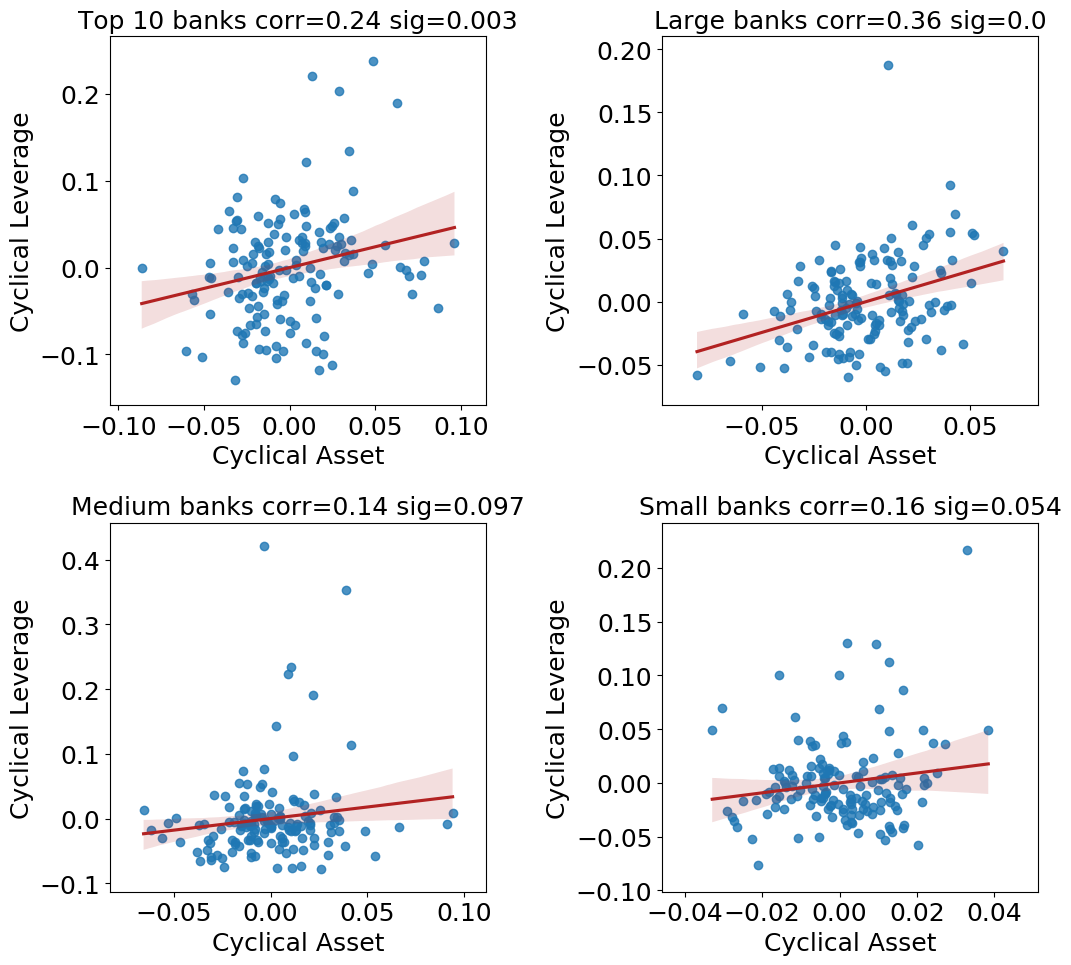

In [265]:
fig, ax = plt.subplots(2,2, figsize=(11,10))
ax = ax.ravel()

count_cat = 4

for i in range(count_cat):
    temp = array_cats_liab_raw_sum[i].shift(-3).dropna()
    cycle_leverage1, trend_leverage = sm.tsa.filters.hpfilter(np.log(temp.leverage), 1600)
    
    temp = array_cats_liab_raw_sum[i].assets
    cycle_assets1, trend_assets = sm.tsa.filters.hpfilter(np.log(array_cats_liab_raw_sum[i][:-3].assets), 1600)
    
    sns.regplot(x=cycle_assets1, y=cycle_leverage1, ax=ax[i], line_kws={"color":'firebrick'})
    
    tuple_corr = scipy.pearsonr(cycle_leverage1, cycle_assets1)
    
    ax[i].set_title(categories[i] +  " corr=" + str(tuple_corr[0].round(2)) + " sig=" + str(tuple_corr[1].round(3)))
    
    ax[i].set_ylabel("Cyclical Leverage")
    
    ax[i].set_xlabel("Cyclical Asset")
    
    
plt.tight_layout()


plt.savefig('LatexVorlage/graphs/DescriptiveStats/BanksbyAssetsCategory_ScatterAverageLeveragevsAggregateAssetsCat_7613.png')

Scatterplot: Aggregate Leverage

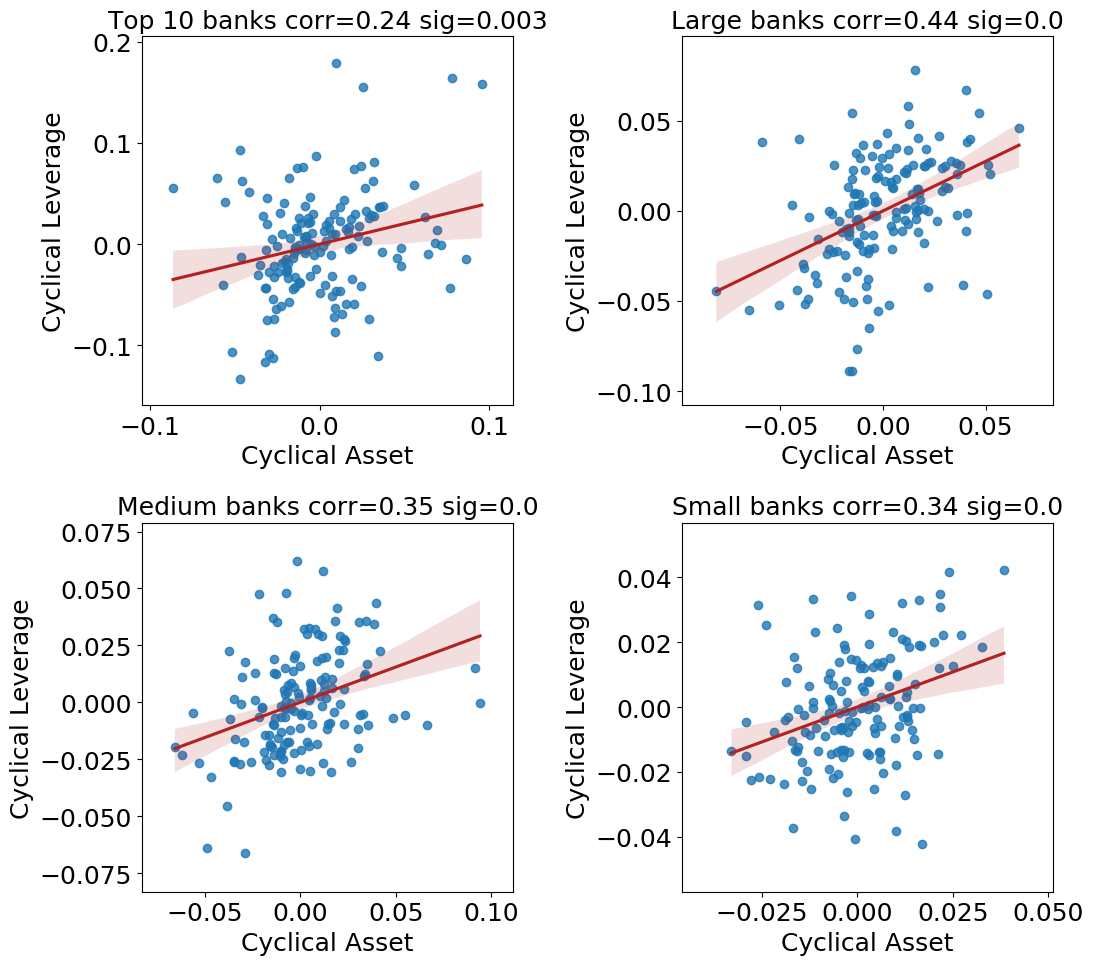

In [266]:
fig, ax = plt.subplots(2,2, figsize=(11,10))
ax = ax.ravel()

count_cat = 4

for i in range(count_cat):
    cycle_leverage, trend_leverage = sm.tsa.filters.hpfilter(np.log(array_cats_liab_raw_sum[i].assets/array_cats_liab_raw_sum[i].equity), 1600)
    
    cycle_assets, trend_leverage = sm.tsa.filters.hpfilter(np.log(array_cats_liab_raw_sum[i].assets), 1600)
    
    sns.regplot(x=cycle_assets, y=cycle_leverage, ax=ax[i], line_kws={"color":'firebrick'})
    
    tuple_corr = scipy.pearsonr(cycle_leverage, cycle_assets)
    
    ax[i].set_title(categories[i] +  " corr=" + str(tuple_corr[0].round(2)) + " sig=" + str(tuple_corr[1].round(3)))
    
    ax[i].set_ylabel("Cyclical Leverage")
    
    ax[i].set_xlabel("Cyclical Asset")
    
    
plt.tight_layout()


plt.savefig('LatexVorlage/graphs/DescriptiveStats/BanksbyAssetsCategory_ScatterAggregateLeveragevsAggregateAssetsCat_7613.png')

Procyclicality over time ranges

For Average Cyclical Computation

In [267]:


def compute_correlations(dataFrameArray):
    year_begin = 1980

    corr_per_range_cat = []

    #corr_per_range = []

    #loop for categories
    for i in range(4):
        #loop for time ranges
        corr_per_range = []
        year_begin = 1980
        temp = dataFrameArray[i]
        for j in range(3):
            #temp = dataFrameArray[i]
            #get range
            leverage_range = temp[(temp.index > str(year_begin)) & (temp.index < str(year_begin+10))].leverage
            asset_range = temp[(temp.index > str(year_begin)) & (temp.index < str(year_begin+10))].assets
    
            #compute cycle for range
            cycle_leverage, trend_all = sm.tsa.filters.hpfilter(np.log(leverage_range), 1600)
            cycle_assets, trend_all = sm.tsa.filters.hpfilter(np.log(asset_range), 1600)
            
            #add corr per range to array
            corr = scipy.pearsonr(cycle_leverage, cycle_assets)
            
            #round tuple numbers
            corr_per_range.append(tuple(round(x,3) for x in corr))
            #print(corr_per_range)
            
            #increment range year
            year_begin += 10
            
        #append to cat correlation array
        corr_per_range_cat.append(corr_per_range)
            

    array_ranges = ["1980-1990", "1990-2000", "2000-2010"]

    list_df = []

    for y in range(4):
        temp_df = pd.DataFrame(corr_per_range_cat[y], columns=['Correlation', "Significance"])
        
        temp_df["year_range"] = array_ranges
        temp_df = temp_df.set_index("year_range")
    
        list_df.append(temp_df)
    
    return pd.concat(list_df, keys=["Top 10 banks", "Large banks", "Medium banks", "Small banks"])

In [268]:
compute_correlations(array_cats_liab_raw_mean).to_latex("LatexVorlage/graphs/Tables/LatexTables/corr_average_range_cat.tex")

compute_correlations(array_cats_liab_raw_mean)


Correlation  Significance
             year_range                           
Top 10 banks 1980-1990          0.15          0.34
             1990-2000         0.075          0.65
             2000-2010           0.3         0.063
Large banks  1980-1990          0.25          0.12
             1990-2000          0.58           0.0
             2000-2010         0.072          0.66
Medium banks 1980-1990          0.23          0.16
             1990-2000        -0.041           0.8
             2000-2010         -0.26           0.1
Small banks  1980-1990         0.086           0.6
             1990-2000          0.36         0.022
             2000-2010        -0.086           0.6

In [269]:
for i in range(len(array_cats_liab_raw_sum)):
    array_cats_liab_raw_sum[i]["leverage"] = array_cats_liab_raw_sum[i]["assets"] / array_cats_liab_raw_sum[i]["equity"]

array_cats_liab_raw_sum[2].leverage

date
1976-03-31   1.4e+01
1976-06-30   1.4e+01
1976-09-30   1.4e+01
1976-12-31   1.5e+01
1977-03-31   1.4e+01
1977-06-30   1.4e+01
1977-09-30   1.4e+01
1977-12-31   1.5e+01
1978-03-31   1.5e+01
1978-06-30   1.5e+01
1978-09-30   1.5e+01
1978-12-31   1.5e+01
1979-03-31   1.5e+01
1979-06-30   1.5e+01
1979-09-30   1.5e+01
1979-12-31   1.5e+01
1980-03-31   1.5e+01
1980-06-30   1.5e+01
1980-09-30   1.5e+01
1980-12-31   1.5e+01
1981-03-31   1.5e+01
1981-06-30   1.5e+01
1981-09-30   1.5e+01
1981-12-31   1.5e+01
1982-03-31   1.5e+01
1982-06-30   1.5e+01
1982-09-30   1.5e+01
1982-12-31   1.5e+01
1983-03-31   1.5e+01
1983-06-30   1.5e+01
1983-09-30   1.5e+01
1983-12-31   1.6e+01
1984-03-31   1.5e+01
1984-06-30   1.5e+01
1984-09-30   1.5e+01
1984-12-31   1.6e+01
1985-03-31   1.5e+01
1985-06-30   1.5e+01
1985-09-30   1.5e+01
1985-12-31   1.5e+01
1986-03-31   1.5e+01
1986-06-30   1.5e+01
1986-09-30   1.5e+01
1986-12-31   1.5e+01
1987-03-31   1.5e+01
1987-06-30   1.5e+01
1987-09-30   1.4e+01
1987-12-

In [270]:
compute_correlations(array_cats_liab_raw_sum).to_latex("LatexVorlage/graphs/Tables/LatexTables/corr_agg_range_cat.tex")

compute_correlations(array_cats_liab_raw_sum)

Correlation  Significance
             year_range                           
Top 10 banks 1980-1990          0.21           0.2
             1990-2000          0.08          0.62
             2000-2010          0.37         0.018
Large banks  1980-1990          0.21          0.18
             1990-2000          0.67           0.0
             2000-2010          0.22          0.18
Medium banks 1980-1990          0.57           0.0
             1990-2000          0.48         0.002
             2000-2010         0.036          0.83
Small banks  1980-1990          0.56           0.0
             1990-2000          0.55           0.0
             2000-2010          -0.2          0.21

For Aggregate Cyclical Computation

In [271]:
import statsmodels.api as sm
from sklearn import preprocessing


x = cycle_assets
y = cycle_leverage

x = preprocessing.scale(x)
y = preprocessing.scale(y)

x = sm.add_constant(x)

model = sm.OLS(y,x)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     19.25
Date:                Wed, 29 Jul 2020   Prob (F-statistic):           2.15e-05
Time:                        15:07:45   Log-Likelihood:                -206.50
No. Observations:                 152   AIC:                             417.0
Df Residuals:                     150   BIC:                             423.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.776e-17      0.077   3.61e-16      1.000      -0.152       0.152
x1             0.3373      0.077      4.388      0.000       0.185       0.489
==============================================================================
Omnibus:                        1.982   Durbin-Watson:                   0.885
Prob(Omnibus):                  0.371   Jarque-Bera (JB):                1.672
Skew:                          -0.072   Prob(JB):                        0.434
Kurtosis:                       3.493   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

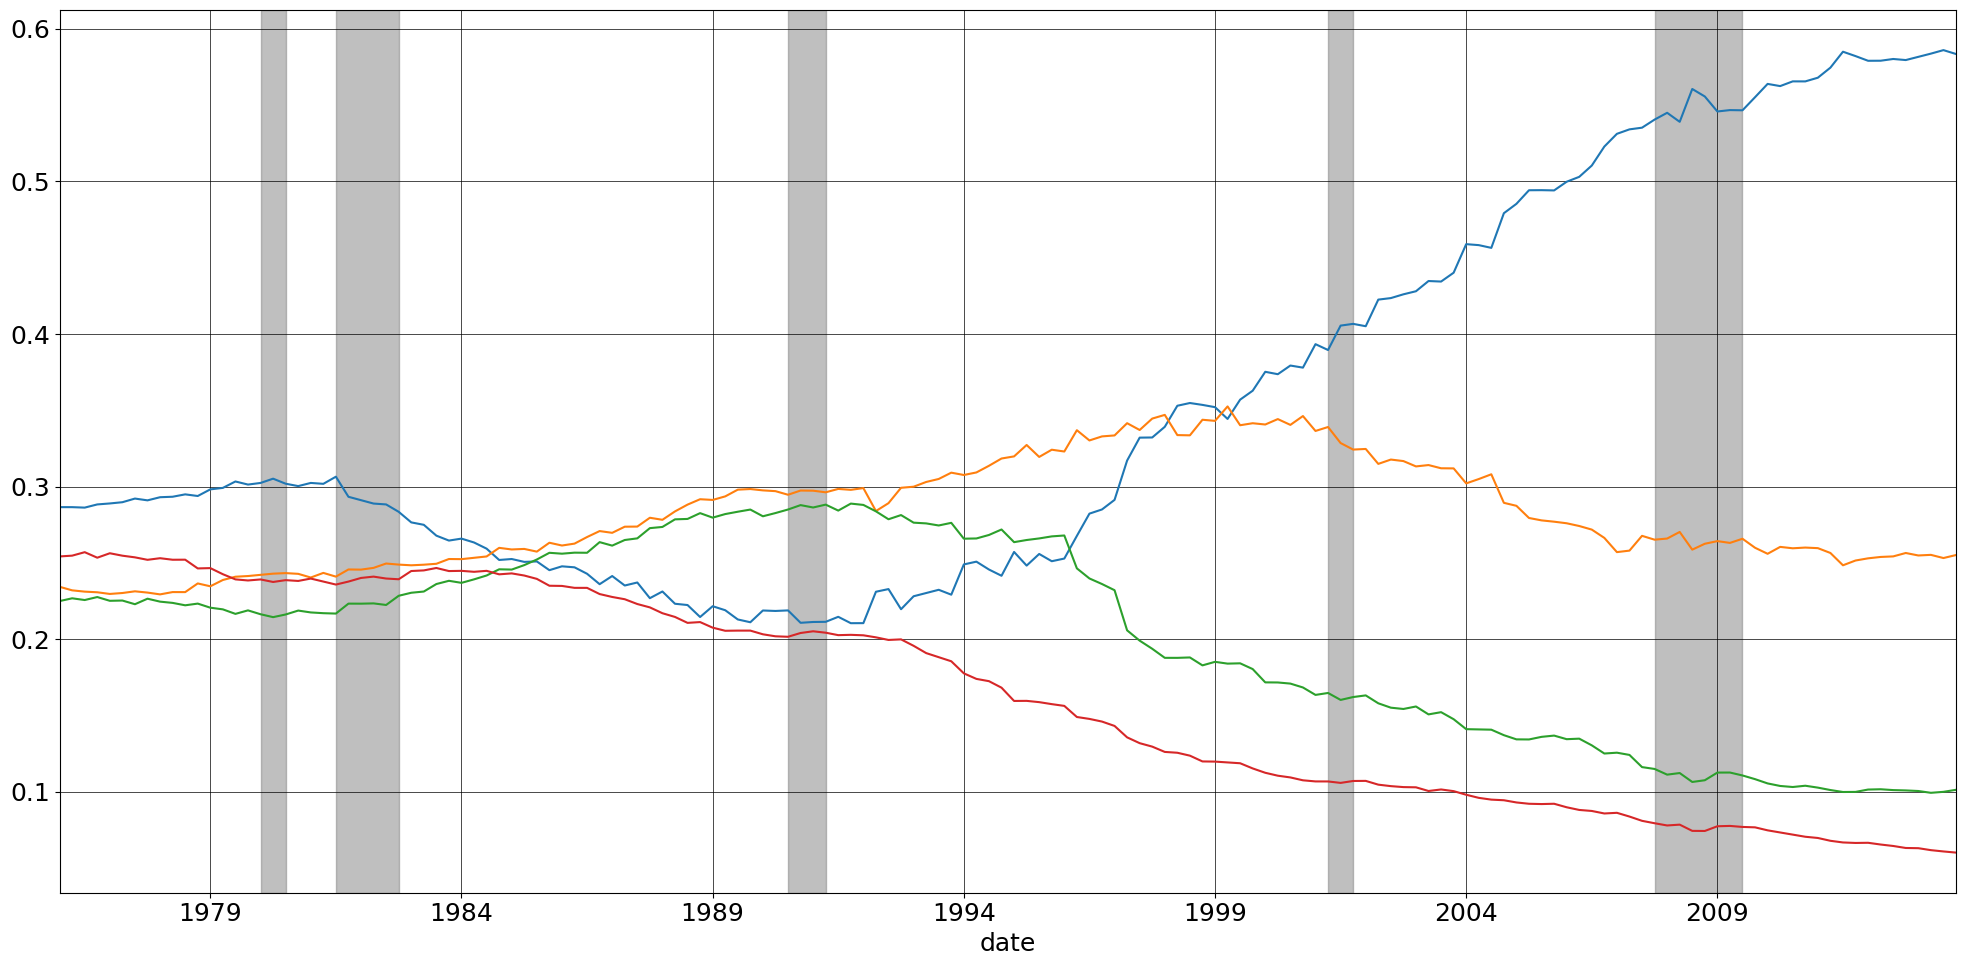

In [272]:
fig, ax = plt.subplots(figsize=(20,10))

df_assets_agg = df_assets.groupby("date").sum()

for cat in array_cats_asset_raw:
    cat["share_assets"] = cat["assets"]/df_assets_agg["assets"]
    cat["share_assets"].plot(ax=ax)


axsetting2(ax)

    
plt.tight_layout()
plt.savefig('LatexVorlage/graphs/DescriptiveStats/BanksbyAssetsCategory_ShareAssetsByCat_7613.png')